# TP Final Integrador Visión por Computadora II - CEIA - FIUBA - Cohorte 16

Alumnos: Fabricio Lopretto (a1616) y Santiago José Olaciregui (a1611)

## Implementación de optimización de hiperparámetros sobre Red CNN para el clasificador objetos (pipeline Clasificador CNN definido posterior a red YOLO utilizada).

### Objetivos:

Realizar el una búsqueda de hiperparámetros sobre el pipeline clasificador de objetos propuesto de forma alternativa a la componente clasificadora de la red YOLO empleada.

### Características:

Debido a la gran demanda computacional que la tarea requiere, se emplea un conjunto de datos más pequeño sobre el cual se realizará la optimización de hiperparámetros. Si bien los resultados no serán tan buenos como si se utilizaran todos los datos, serán lo suficiente para optimizar la configuración de la red.

In [ ]:
# Instala los módulos necesarios
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install requests beautifulsoup4
!pip3 install torch torchvision torchaudio
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 23.2 MB/s eta 0:00:00


In [ ]:
# Importa las librerías necesarias
from google.colab import drive
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
from IPython.display import display
from pathlib import Path
from ultralytics import YOLO
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torchvision.transforms as transforms

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Clona el repositorio de GitHub
!git clone https://github.com/fabriciolopretto/VpC2.git

Cloning into 'VpC2'...
remote: Enumerating objects: 24305, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 24305 (delta 0), reused 0 (delta 0), pack-reused 24304 (from 1)
Receiving objects: 100% (24305/24305), 674.49 MiB | 23.73 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (30583/30583), done.


# Red YOLO: Detección de los objetos (guarda en detection como train/val)

### Ejecución del modelo:

**Carga del modelo YOLOv8.** Se utiliza un modelo preentrenado (weights inicializados) basado en la arquitectura YOLOv8n. En el código, cuando se instancia el modelo con YOLO(MODEL_NAME) (donde MODEL_NAME = "yolov8n"), el framework carga automáticamente los pesos preentrenados en el dataset COCO. Estos pesos contienen conocimiento general que el modelo ha aprendido, como la capacidad de detectar bordes, esquinas, y formas básicas. COCO incluye clases como "números" o "carteles", que comparten similitudes con los números en las cartas UNO. Luego, durante el entrenamiento con el nuevo dataset, los pesos del modelo se ajustan gradualmente para adaptarse al dataset específico de las cartas del juego UNO. Las primeras capas (cercanas a la entrada) se ajustan poco o nada, porque representan características genéricas (como bordes o texturas).Las últimas capas (cercanas a la salida) se reentrenan para reconocer las características y clases específicas de las cartas. El modelo se ajusta para reconocer los números y posiblemente las características únicas de las cartas UNO (formas, colores, texturas).

**Data Augumentation.** Se aplica automáticamente para enriquecer las muestras de entrenamiento. Entre las operaciones realizadas se tiene escalado manteniendo las proporciones, rotación en un rango de ángulos, recorte aleatorio de partes de las imagenes, traslación dentro del dominio de la imagen, ajuste de brillo, saturación y de contraste, introducción de ruido y mezcla de imagenes. Además, cada lote de entrenamiento recibe transformaciones únicas. No todas las operaciones se aplican a cada imagen; hay una probabilidad definida para cada una (por ejemplo, un 50% para rotaciones o un 30% para cambios de brillo).

**Workers.** Procesos en paralelo (4) para acelerar el preprocesamiento de datos.

**Evaluación.** Se evalúa el modelo en el conjunto de prueba definido en el archivo YAML. Para esto, utiliza métricas como mAP@50 (precisión promedio para un umbral de IoU: Intersection over Union) y/o mAP@50-95 como (precisión promedio en un rango de umbrales 50% a 95%).

**Resultados**: Los resultados (pesos entrenados, gráficos de pérdida, métricas) se guardan en el directorio runs/detect/UNO_detection.

In [ ]:
# -----------------------------
# Configuración inicial
# -----------------------------
DATASET_DIR = "/content/VpC2/"  # Ruta del repositorio clonado en Google Colab
TRAIN_IMAGES_DIR = os.path.join(DATASET_DIR, "data/data_original/train/images/")
TRAIN_LABELS_DIR = os.path.join(DATASET_DIR, "data/data_original/train/labels/")
TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "data/data_original/test/images/")
TEST_LABELS_DIR = os.path.join(DATASET_DIR, "data/data_original/test/labels/")

# Archivo de configuración de datos para YOLOv8
DATA_YAML = """
train: /content/VpC2/data/data_original/train/images/
val: /content/VpC2/data/data_original/test/images/

nc: 15  # Número de clases
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']
"""
DATA_YAML_PATH = Path(DATASET_DIR) / "data.yaml"
with open(DATA_YAML_PATH, "w") as file:
    file.write(DATA_YAML)
print(f"Archivo YAML guardado en: {DATA_YAML_PATH}")

# Hiperparámetros del entrenamiento
MODEL_NAME = "yolov8n"  # Arquitectura (nano)
EPOCHS = 50
BATCH_SIZE = 16
IMAGE_SIZE = 416

# -----------------------------
# Entrenamiento
# -----------------------------
def train_yolov8():
    print("Iniciando entrenamiento YOLOv8...")
    model = YOLO(MODEL_NAME)
    model.train(
        data=str(DATA_YAML_PATH),
        epochs=EPOCHS,
        batch=BATCH_SIZE,
        imgsz=IMAGE_SIZE,
        workers=4,
        augment=True,
        name="UNO_detection"
    )
    print("Entrenamiento finalizado.")

# -----------------------------
# Evaluación
# -----------------------------
def evaluate_yolov8():
    print("Evaluando el modelo YOLOv8...")
    model = YOLO(f"runs/detect/UNO_detection/weights/best.pt")
    results = model.val(data=str(DATA_YAML_PATH), imgsz=IMAGE_SIZE)
    print(f"mAP@50: {results.box.map50:.4f}, mAP@50-95: {results.box.map:.4f}")

# -----------------------------
# Guardar Recortes y Etiquetas (solo clases) en "train" o "val"
# -----------------------------
def save_detections(model, images_dir, output_dir, folder_name):
    """
    Procesa imágenes para guardar recortes, etiquetas y un archivo .txt por cada recorte en la carpeta 'train' o 'val'.
    :param model: Modelo YOLO cargado.
    :param images_dir: Carpeta con las imágenes para procesar.
    :param output_dir: Carpeta base para guardar los resultados (recortes y etiquetas).
    :param folder_name: Nombre de la carpeta ('train' o 'val') donde se guardarán los recortes.
    """
    print(f"Procesando imágenes para guardar detecciones en '{folder_name}'...")
    folder_path = os.path.join(output_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)

    log_path = os.path.join(folder_path, "processing_log.txt")
    with open(log_path, "w") as log_file:
        for image_file in os.listdir(images_dir):
            if image_file.lower().endswith(('.jpg', '.png', '.jpeg')):  # Solo procesar imágenes
                try:
                    # Ruta de la imagen
                    image_path = os.path.join(images_dir, image_file)
                    img = cv2.imread(image_path)

                    # Realizar predicción con YOLO
                    results = model(image_path)
                    base_name = os.path.splitext(image_file)[0]

                    # Guardar recortes, etiquetas y archivo .txt para cada recorte
                    for i, detection in enumerate(results[0].boxes):
                        cls = int(detection.cls)  # Clase del objeto detectado
                        label = str(cls)  # Convertir la clase en un string

                        # Recortar y guardar imagen del objeto detectado
                        x1, y1, x2, y2 = detection.xyxy[0]
                        crop = img[int(y1):int(y2), int(x1):int(x2)]
                        crop_file = os.path.join(folder_path, f"{base_name}_{i}.jpg")
                        cv2.imwrite(crop_file, crop)

                        # Guardar la etiqueta de la clase en un archivo .txt para este recorte
                        label_file = os.path.join(folder_path, f"{base_name}_{i}.txt")
                        with open(label_file, "w") as lf:
                            lf.write(f"{label}\n")  # Guardar la clase como texto

                    log_file.write(f"{image_file}: Procesado correctamente.\n")
                except Exception as e:
                    log_file.write(f"{image_file}: Error - {str(e)}\n")

    print(f"Recortes, etiquetas y archivos .txt guardados en: {folder_path}")


# -----------------------------
# Función principal
# -----------------------------
def process_detections():
    OUTPUT_DIR = "/content/detections"
    MODEL_PATH = "runs/detect/UNO_detection/weights/best.pt"
    model = YOLO(MODEL_PATH)

    # Guardar las detecciones de 'train'
    save_detections(model, TRAIN_IMAGES_DIR, OUTPUT_DIR, "train")

    # Guardar las detecciones de 'val'
    save_detections(model, TEST_IMAGES_DIR, OUTPUT_DIR, "val")

if __name__ == "__main__":
    # 1. Entrena el modelo
    train_yolov8()

    # 2. Evalua el modelo
    evaluate_yolov8()

    # 3. Guardar detecciones (train y val)
    process_detections()


Archivo YAML guardado en: /content/VpC2/data.yaml
Iniciando entrenamiento YOLOv8...


100%|██████████| 6.25M/6.25M [00:00<00:00, 101MB/s]


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/VpC2/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=UNO_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 91.2MB/s]


AMP: checks passed ✅


train: Scanning /content/VpC2/data/data_original/train/labels... 6295 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6295/6295 [00:03<00:00, 1616.82it/s]


train: New cache created: /content/VpC2/data/data_original/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/VpC2/data/data_original/test/labels... 899 images, 0 backgrounds, 0 corrupt: 100%|██████████| 899/899 [00:00<00:00, 1047.70it/s]


val: New cache created: /content/VpC2/data/data_original/test/labels.cache
Plotting labels to runs/detect/UNO_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/UNO_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.05G      1.318      3.036     0.9551         31        416: 100%|██████████| 394/394 [01:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.66it/s]


                   all        899       2697      0.637      0.709      0.719      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.986G     0.9593      1.304     0.8733         23        416: 100%|██████████| 394/394 [01:19<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]

                   all        899       2697      0.948      0.934      0.981      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.994G     0.8657     0.9392     0.8554         32        416: 100%|██████████| 394/394 [01:17<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.96it/s]

                   all        899       2697      0.967      0.968      0.991      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.992G     0.8134     0.7883      0.845         26        416: 100%|██████████| 394/394 [01:17<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.84it/s]

                   all        899       2697      0.983      0.986      0.992      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.988G     0.7673      0.701     0.8367         42        416: 100%|██████████| 394/394 [01:17<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.84it/s]

                   all        899       2697      0.978      0.985      0.988      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.03G     0.7375     0.6285     0.8294         24        416: 100%|██████████| 394/394 [01:16<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]

                   all        899       2697      0.978      0.989       0.99       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.992G     0.7148      0.587     0.8267         29        416: 100%|██████████| 394/394 [01:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.98it/s]

                   all        899       2697      0.981       0.98      0.988      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.02G     0.6895     0.5513     0.8251         39        416: 100%|██████████| 394/394 [01:16<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.47it/s]

                   all        899       2697       0.99      0.992       0.99      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.988G     0.6827     0.5289      0.822         24        416: 100%|██████████| 394/394 [01:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]

                   all        899       2697      0.991      0.992      0.989      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      0.99G      0.661     0.5027     0.8201         52        416: 100%|██████████| 394/394 [01:16<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.84it/s]

                   all        899       2697      0.992      0.994       0.99      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.981G     0.6554     0.4864     0.8166         32        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.82it/s]

                   all        899       2697      0.984      0.992       0.99       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.992G      0.647     0.4771     0.8162         15        416: 100%|██████████| 394/394 [01:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.63it/s]

                   all        899       2697      0.993      0.993      0.993      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.994G     0.6358     0.4588     0.8164         32        416: 100%|██████████| 394/394 [01:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.81it/s]

                   all        899       2697      0.993      0.994      0.993      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.984G     0.6258     0.4495     0.8124         38        416: 100%|██████████| 394/394 [01:17<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.12it/s]

                   all        899       2697      0.985      0.987      0.989       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.986G     0.6224     0.4416     0.8129         27        416: 100%|██████████| 394/394 [01:31<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]

                   all        899       2697      0.995      0.997      0.994       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.988G     0.6205     0.4351     0.8116         27        416: 100%|██████████| 394/394 [01:33<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.23it/s]

                   all        899       2697      0.989      0.991      0.989      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.02G      0.613      0.425     0.8115         44        416: 100%|██████████| 394/394 [01:36<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.42it/s]

                   all        899       2697      0.994      0.996      0.993       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.02G     0.6026     0.4145     0.8117         12        416: 100%|██████████| 394/394 [01:32<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]

                   all        899       2697      0.992      0.992      0.991      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.988G     0.5988     0.4127     0.8091         27        416: 100%|██████████| 394/394 [01:38<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.95it/s]

                   all        899       2697      0.993      0.995      0.993      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.02G     0.5916     0.4017     0.8095         37        416: 100%|██████████| 394/394 [01:41<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.78it/s]

                   all        899       2697      0.992      0.994      0.992      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.03G     0.5859     0.4015     0.8064         26        416: 100%|██████████| 394/394 [01:40<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.21it/s]

                   all        899       2697      0.991      0.994      0.992      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.02G     0.5805     0.3896     0.8083         35        416: 100%|██████████| 394/394 [01:38<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.51it/s]

                   all        899       2697      0.993      0.995      0.992      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.994G     0.5778     0.3909     0.8073         24        416: 100%|██████████| 394/394 [01:40<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]

                   all        899       2697      0.994      0.996      0.993      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.02G     0.5712     0.3795     0.8055         33        416: 100%|██████████| 394/394 [01:25<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.05it/s]

                   all        899       2697      0.992      0.991       0.99      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      0.99G     0.5678     0.3794     0.8046         31        416: 100%|██████████| 394/394 [01:13<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.33it/s]

                   all        899       2697      0.993      0.994      0.992      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.994G       0.57     0.3733     0.8057         28        416: 100%|██████████| 394/394 [01:14<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.92it/s]

                   all        899       2697      0.992      0.993      0.991      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.992G     0.5633     0.3695     0.8043         25        416: 100%|██████████| 394/394 [01:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]

                   all        899       2697      0.993      0.995      0.992      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.992G     0.5558     0.3704     0.8034         27        416: 100%|██████████| 394/394 [01:13<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.98it/s]

                   all        899       2697      0.991      0.993      0.991      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.986G     0.5557     0.3642     0.8039         28        416: 100%|██████████| 394/394 [01:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.62it/s]

                   all        899       2697      0.991      0.994      0.989      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.02G     0.5513     0.3594     0.8027         39        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.99it/s]

                   all        899       2697      0.992      0.994      0.992      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.986G      0.549     0.3575     0.8025         24        416: 100%|██████████| 394/394 [01:15<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.41it/s]

                   all        899       2697      0.994      0.995      0.992      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      0.99G     0.5431     0.3542     0.8017         39        416: 100%|██████████| 394/394 [01:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.78it/s]

                   all        899       2697      0.992      0.995      0.992      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.03G     0.5358     0.3476     0.8019         24        416: 100%|██████████| 394/394 [01:16<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.28it/s]

                   all        899       2697       0.99      0.995      0.992      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.03G     0.5358     0.3448     0.8002         21        416: 100%|██████████| 394/394 [01:16<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.84it/s]

                   all        899       2697      0.992      0.994      0.991      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.988G     0.5359      0.345     0.8011         25        416: 100%|██████████| 394/394 [01:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.01it/s]

                   all        899       2697      0.993      0.995      0.992      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.994G     0.5306     0.3403     0.7993         29        416: 100%|██████████| 394/394 [01:13<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.92it/s]

                   all        899       2697      0.993      0.995      0.992      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.984G     0.5264     0.3396     0.8011         12        416: 100%|██████████| 394/394 [01:14<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.00it/s]

                   all        899       2697      0.993      0.994      0.993      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.03G     0.5236     0.3345     0.7997         22        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.90it/s]

                   all        899       2697      0.992      0.994      0.992      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.994G     0.5199      0.333     0.7998         25        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.06it/s]

                   all        899       2697      0.992      0.994      0.991      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.03G     0.5172     0.3304     0.7979         27        416: 100%|██████████| 394/394 [01:28<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.88it/s]


                   all        899       2697      0.992      0.995      0.991      0.899
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.984G     0.4784     0.2731     0.7905         21        416: 100%|██████████| 394/394 [01:32<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.48it/s]

                   all        899       2697      0.993      0.995      0.993      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.984G     0.4707     0.2692       0.79         21        416: 100%|██████████| 394/394 [01:17<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.21it/s]

                   all        899       2697      0.992      0.995      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.984G      0.469     0.2678     0.7894         21        416: 100%|██████████| 394/394 [01:11<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.12it/s]

                   all        899       2697      0.993      0.996      0.993      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.984G     0.4659     0.2634     0.7889         21        416: 100%|██████████| 394/394 [01:12<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]

                   all        899       2697      0.993      0.996      0.993      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.984G     0.4601     0.2599      0.788         21        416: 100%|██████████| 394/394 [01:12<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]

                   all        899       2697      0.993      0.995      0.993      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.984G     0.4552     0.2561     0.7875         21        416: 100%|██████████| 394/394 [01:14<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.93it/s]

                   all        899       2697      0.992      0.995      0.993      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.984G     0.4557     0.2575     0.7869         21        416: 100%|██████████| 394/394 [01:36<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]

                   all        899       2697      0.993      0.995      0.993      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.984G     0.4503     0.2526     0.7872         21        416: 100%|██████████| 394/394 [01:33<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]

                   all        899       2697      0.992      0.996      0.993      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.984G     0.4484     0.2509     0.7872         21        416: 100%|██████████| 394/394 [01:15<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.61it/s]

                   all        899       2697      0.992      0.995      0.992       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.984G     0.4465     0.2489     0.7867         21        416: 100%|██████████| 394/394 [01:14<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.44it/s]

                   all        899       2697      0.992      0.994      0.992      0.912



50 epochs completed in 1.226 hours.
Optimizer stripped from runs/detect/UNO_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/UNO_detection/weights/best.pt, 6.2MB

Validating runs/detect/UNO_detection/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.69it/s]


                   all        899       2697       0.99      0.994      0.993      0.886
                     0        166        175      0.995          1      0.995      0.904
                     1        153        160      0.999          1      0.995      0.885
                     2        165        171      0.986          1      0.995      0.908
                     3        190        205      0.997          1      0.995      0.894
                     4        168        183      0.998          1      0.995      0.902
                     5        164        179      0.992          1      0.995      0.904
                     6        175        190      0.994          1      0.995       0.88
                     7        177        189      0.997          1      0.995      0.897
                     8        170        192      0.988          1      0.995      0.878
                     9        179        187      0.998          1      0.995      0.883
                    1

val: Scanning /content/VpC2/data/data_original/test/labels.cache... 899 images, 0 backgrounds, 0 corrupt: 100%|██████████| 899/899 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:08<00:00,  6.99it/s]


Se truncaron las últimas líneas 5000 del resultado de transmisión.
image 1/1 /content/VpC2/data/data_original/train/images/164986888_jpg.rf.9a70c92902cc7bedee9a69566daea110.jpg: 416x416 1 3, 1 9, 2 10s, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/VpC2/data/data_original/train/images/163507983_jpg.rf.239a5c6d6fc3dd250cb153e967bce0b4.jpg: 416x416 1 7, 2 14s, 13.1ms
Speed: 1.3ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/VpC2/data/data_original/train/images/817935544_jpg.rf.8dce54ccf660cd3e2d81b90307cdc267.jpg: 416x416 1 0, 1 3, 1 12, 10.7ms
Speed: 1.1ms preprocess, 10.7ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/VpC2/data/data_original/train/images/308617938_jpg.rf.06b8dbc7965fb2281b5b289fd126aee6.jpg: 416x416 1 5, 1 6, 1 9, 12.4ms
Speed: 1.3ms preprocess, 12.4ms inference, 2.7ms postprocess per image at sha

# Pipiline de Red CNN de Clasificación (calcula y grafica Pérdidas, .Accuracy, Precisión y Recall)

## Definición del Dataset (UNOCardDataset)

**__init__:**
Recibe dos directorios como argumentos: uno para imágenes (images_dir) y otro para etiquetas (labels_dir). Filtra los archivos .jpg en images_dir para obtener una lista de image_files.

**__getitem__:** Carga una imagen desde images_dir y su correspondiente etiqueta desde labels_dir usando el nombre del archivo. Convierte la imagen de BGR a RGB usando cv2.cvtColor. Aplica transformaciones si se han definido previamente. Devuelve la imagen transformada y la etiqueta.

## Definición del Modelo CNN (CNNModel)
**__init__:** Define la arquitectura de la red neuronal convolucional:
1. Tres capas de convolución (Conv2d).
2. Tres capas de MaxPooling.
3. Dos capas de Linear para transformar la representación de la imagen a una salida de clase.
4. Capa de Dropout para combatir la sobreajuste.

**forward:**
1. Propaga la imagen a través de la red neuronal:
2. Aplica activación ReLU después de cada operación de convolución.
3. Aplana la imagen transformada para alimentar las capas densas (Linear).
4. Finalmente, produce la salida con la última capa de Linear.

## Definición del proceso de entrenamiento (train_model)

**transform:** Se definen transformaciones para redimensionar las imágenes a 128x128, convertirlas a tensor y normalizarlas.
**UNOCardDataset:** Se crean dos objetos UNOCardDataset para el conjunto de entrenamiento y el de validación con las transformaciones definidas anteriormente.

**DataLoader:** Se crean dos objetos DataLoader para iterar sobre el conjunto de entrenamiento y validación, con un batch_size de 32 y shuffle=True para el entrenamiento.

**train_model:**
1. Criterio de pérdida: CrossEntropyLoss para la clasificación.
2. Optimizer: Adam con tasa de aprendizaje de 0.001.
3. Se iteran sobre los datos del conjunto de entrenamiento durante num_epochs

En cada iteración:
1. Propaga las imágenes a través del modelo para obtener las predicciones.
2. Calcula la pérdida usando la función de pérdida.
3. Retropropaga el error usando backward().
4. Actualiza los parámetros con el optimizer.
4. Acumula métricas como precisión, recall, etc.

**evaluate_model:** Se define una función para evaluar el modelo en el conjunto de validación. Calcula la pérdida, precisión, recall y otros valores relevantes.

**plot_metrics:**

Se grafican métricas clave (precisión, recall, pérdida, exactitud) durante el entrenamiento y validación para visualizar la convergencia del modelo.

In [ ]:
# Importa las librerías necesarias
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from torch.utils.data import Subset

### Búsqueda de hiperparámentros en el Pipeline de Clasificación:

Debido a las limitaciones de recursos computacionales, se optó por realizar una búsqueda manual y por partes de hiperparámetros. Es decir, se corrió el modelo de la CNN del Clasificador con diferentes combinaciones de hiperparámetros de forma separada. Intentando imitar un *Random Search* por partes debido, al limitado tiempo disponible de GPU.

Además, debido a las limitaciones, se debió trabajarsobre un sub-conjunto de datos (10%) para mantener los tiempos de ejecución dentro de lo permitido. No obstante, en la mencionada muestra, se mantuvo el balance entre clases para no afectar el desempeño del modelo. En la misma línea, no se pudo realizar una validación cruzada, utilizando en su defecto una búsqueda sobre un lote de entrenamiento y validación en cada combinación de hiperparámetros. Tener presente estas cuestiones, resultó fundamental a la hora de considerar que modelo propuesto resultó mejor opción.

A continuación, se describe el experimento base y sus nueve variantes (modificando sus hiperparámetros).


Entre los hiperparámetros (y los valores base) que se pueden modificar para la optimización son:

1. num_epochs (Número de épocas): 10
2. learning_rate (Tasa de aprendizaje): 0.001
3. batch_size (Tamaño del batch): 32
5. dropout (Dropout): 0.5
6. kernel_size (Tamaño del kernel de las convoluciones): 3

### Experimento Base

Epoch 1/10, Train Loss: 1.3195, Train Accuracy: 59.94%, Validation Loss: 0.7321, Validation Accuracy: 80.86%
Epoch 2/10, Train Loss: 0.6424, Train Accuracy: 81.20%, Validation Loss: 0.6626, Validation Accuracy: 83.83%
Epoch 3/10, Train Loss: 0.4845, Train Accuracy: 85.06%, Validation Loss: 0.6679, Validation Accuracy: 83.17%
Epoch 4/10, Train Loss: 0.4369, Train Accuracy: 85.30%, Validation Loss: 0.6670, Validation Accuracy: 81.52%
Epoch 5/10, Train Loss: 0.3743, Train Accuracy: 86.52%, Validation Loss: 0.7462, Validation Accuracy: 81.85%
Epoch 6/10, Train Loss: 0.3334, Train Accuracy: 88.36%, Validation Loss: 0.7952, Validation Accuracy: 79.54%
Epoch 7/10, Train Loss: 0.2936, Train Accuracy: 89.49%, Validation Loss: 0.7515, Validation Accuracy: 81.19%
Epoch 8/10, Train Loss: 0.2785, Train Accuracy: 89.77%, Validation Loss: 0.8392, Validation Accuracy: 80.86%
Epoch 9/10, Train Loss: 0.2183, Train Accuracy: 91.75%, Validation Loss: 0.8910, Validation Accuracy: 79.87%
Epoch 10/10, Train 

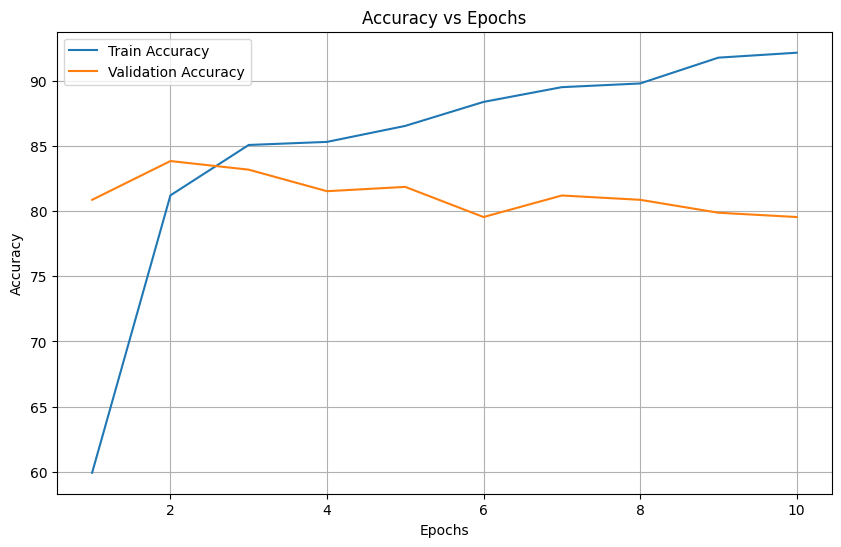

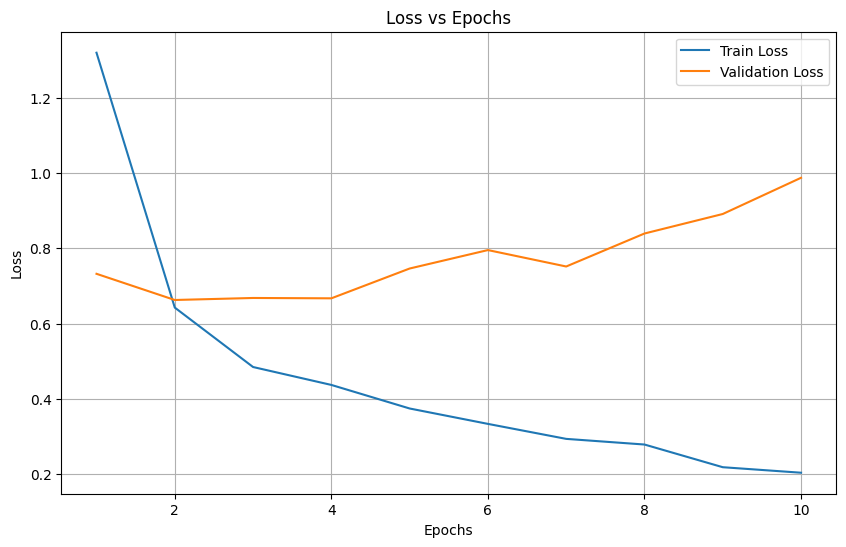

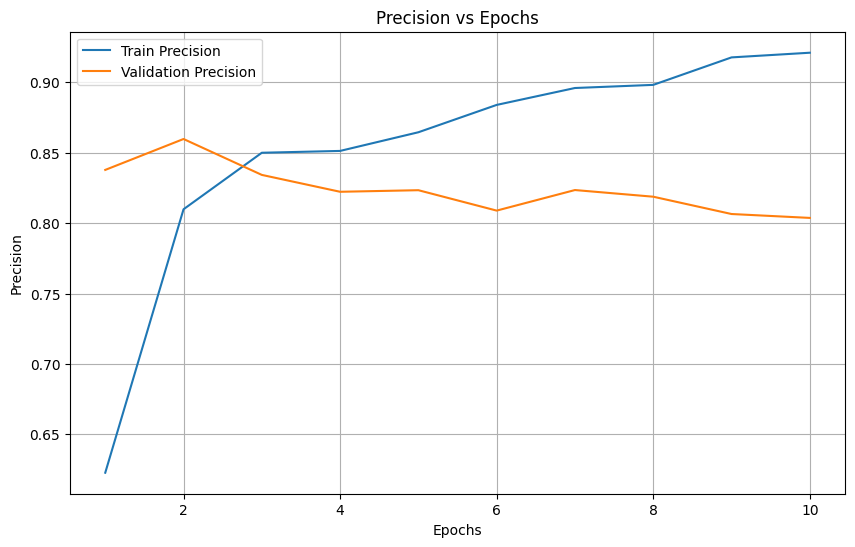

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones (si existen)
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        # Definir la red convolucional
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling con tamaño 2
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adaptar a las dimensiones de la imagen
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Propagar hacia adelante
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Aplanar la salida para las capas densas
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Definir el proceso de entrenamiento ------------------- #
# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar
])

# Cargar los datasets
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Obtener las etiquetas de todos los elementos
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]

# ------------------- Muestreo estratificado ------------------- #
# Obtener el 10% de los datos manteniendo el balance de clases en el conjunto de entrenamiento
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=train_labels)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=val_labels)

# Crear los subconjuntos
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Crear los dataloaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()  # Usamos la entropía cruzada para clasificación
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Métricas por época
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # Calcular métricas para entrenamiento
        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        # Evaluación en el conjunto de validación
        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Graficar métricas
    plot_metrics(metrics)

# Función de evaluación
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# Función para graficar métricas
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics['val_precision'], label='Validation Precision')
    plt.title('Precision vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------- Ejecutar el entrenamiento ------------------- #
# Inicializar el modelo
model = CNNModel(num_classes=15)

# Entrenar el modelo
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)

### Experimento I:

Modificando learning_rate = 0.01

Epoch 1/10, Train Loss: 3.8520, Train Accuracy: 26.15%, Validation Loss: 0.9396, Validation Accuracy: 68.98%
Epoch 2/10, Train Loss: 0.9093, Train Accuracy: 73.66%, Validation Loss: 0.5894, Validation Accuracy: 80.86%
Epoch 3/10, Train Loss: 0.6769, Train Accuracy: 80.35%, Validation Loss: 0.5510, Validation Accuracy: 81.52%
Epoch 4/10, Train Loss: 0.5557, Train Accuracy: 82.94%, Validation Loss: 0.5057, Validation Accuracy: 84.82%
Epoch 5/10, Train Loss: 0.4769, Train Accuracy: 84.64%, Validation Loss: 0.5509, Validation Accuracy: 82.84%
Epoch 6/10, Train Loss: 0.4638, Train Accuracy: 84.92%, Validation Loss: 0.5660, Validation Accuracy: 82.84%
Epoch 7/10, Train Loss: 0.4328, Train Accuracy: 85.06%, Validation Loss: 0.5336, Validation Accuracy: 79.87%
Epoch 8/10, Train Loss: 0.3821, Train Accuracy: 87.46%, Validation Loss: 0.5626, Validation Accuracy: 81.52%
Epoch 9/10, Train Loss: 0.3774, Train Accuracy: 86.85%, Validation Loss: 0.6103, Validation Accuracy: 79.87%
Epoch 10/10, Train 

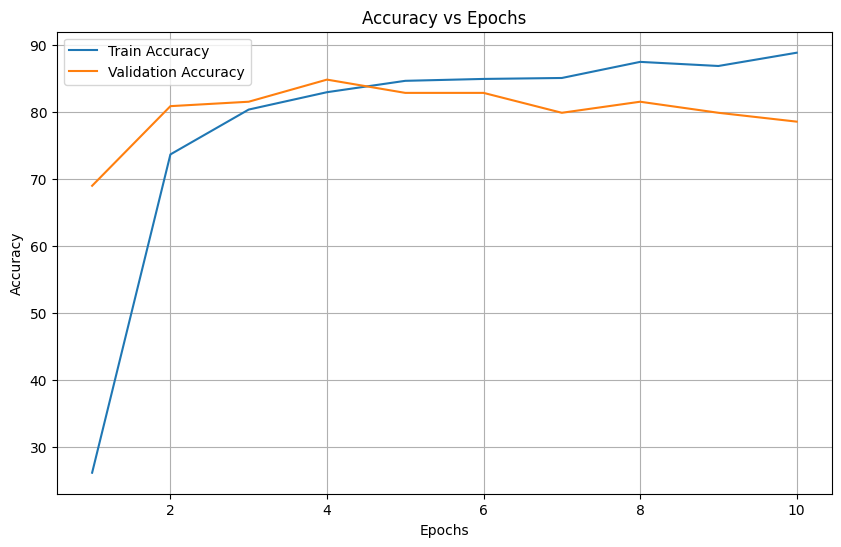

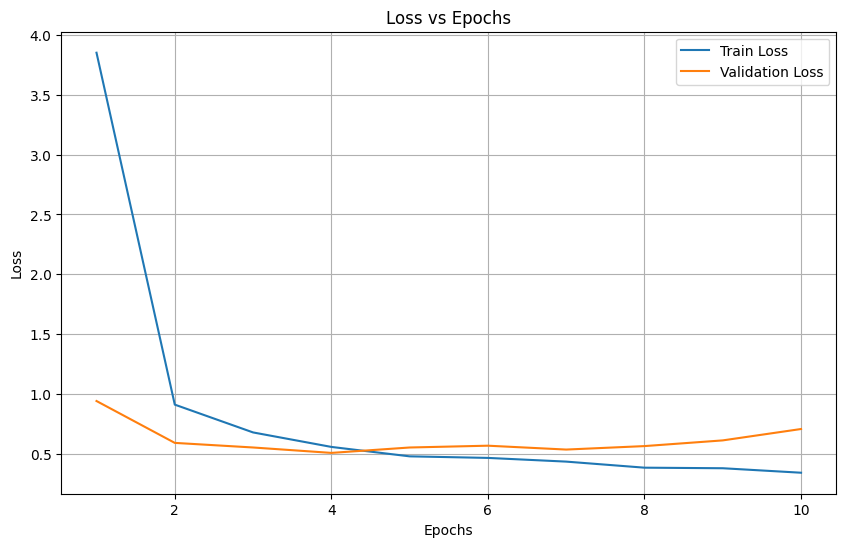

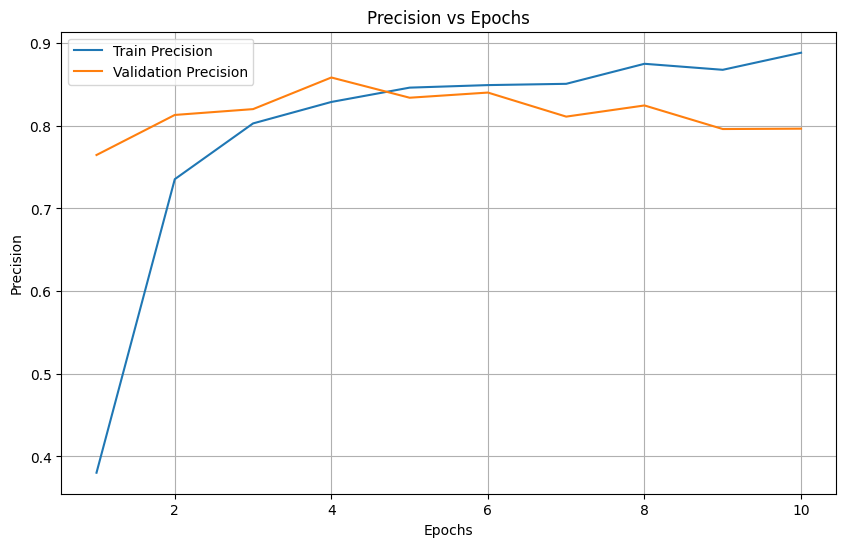

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones (si existen)
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        # Definir la red convolucional
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling con tamaño 2
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adaptar a las dimensiones de la imagen
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Propagar hacia adelante
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Aplanar la salida para las capas densas
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Definir el proceso de entrenamiento ------------------- #
# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar
])

# Cargar los datasets
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Obtener las etiquetas de todos los elementos
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]

# ------------------- Muestreo estratificado ------------------- #
# Obtener el 10% de los datos manteniendo el balance de clases en el conjunto de entrenamiento
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=train_labels)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=val_labels)

# Crear los subconjuntos
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Crear los dataloaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()  # Usamos la entropía cruzada para clasificación
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Métricas por época
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # Calcular métricas para entrenamiento
        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        # Evaluación en el conjunto de validación
        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Graficar métricas
    plot_metrics(metrics)

# Función de evaluación
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# Función para graficar métricas
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics['val_precision'], label='Validation Precision')
    plt.title('Precision vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------- Ejecutar el entrenamiento ------------------- #
# Inicializar el modelo
model = CNNModel(num_classes=15)

# Entrenar el modelo
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.01)


### Experimento II:

Modificando learning_rate = 0.0001

Epoch 1/10, Train Loss: 2.0535, Train Accuracy: 36.29%, Validation Loss: 1.1304, Validation Accuracy: 69.97%
Epoch 2/10, Train Loss: 0.8716, Train Accuracy: 75.54%, Validation Loss: 0.7204, Validation Accuracy: 78.55%
Epoch 3/10, Train Loss: 0.6619, Train Accuracy: 82.14%, Validation Loss: 0.6663, Validation Accuracy: 80.86%
Epoch 4/10, Train Loss: 0.5815, Train Accuracy: 83.36%, Validation Loss: 0.6300, Validation Accuracy: 82.18%
Epoch 5/10, Train Loss: 0.5303, Train Accuracy: 84.35%, Validation Loss: 0.6105, Validation Accuracy: 80.86%
Epoch 6/10, Train Loss: 0.4930, Train Accuracy: 85.44%, Validation Loss: 0.6246, Validation Accuracy: 83.50%
Epoch 7/10, Train Loss: 0.4561, Train Accuracy: 85.96%, Validation Loss: 0.6161, Validation Accuracy: 83.83%
Epoch 8/10, Train Loss: 0.4338, Train Accuracy: 85.82%, Validation Loss: 0.6192, Validation Accuracy: 81.19%
Epoch 9/10, Train Loss: 0.3929, Train Accuracy: 86.99%, Validation Loss: 0.6028, Validation Accuracy: 81.19%
Epoch 10/10, Train 

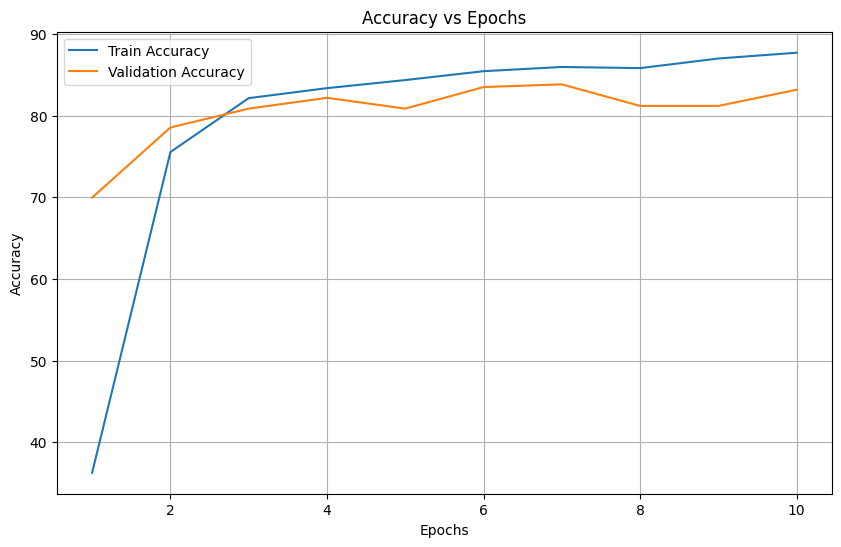

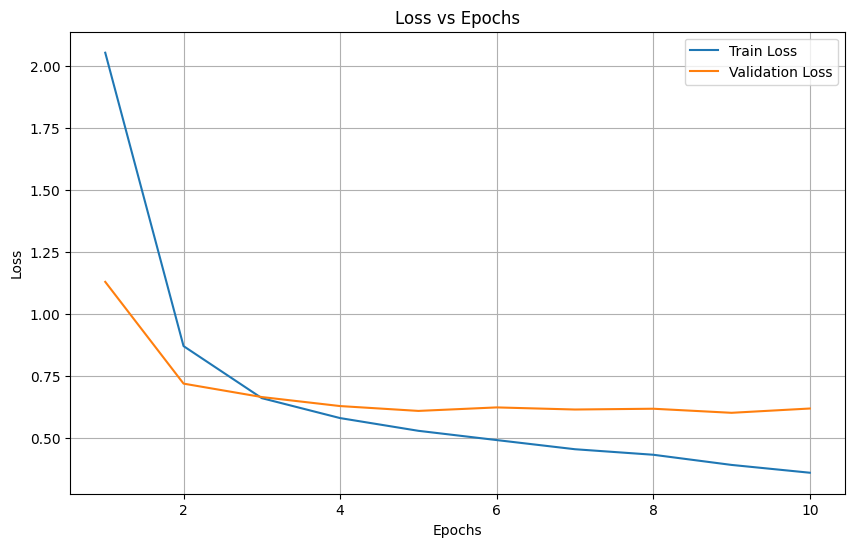

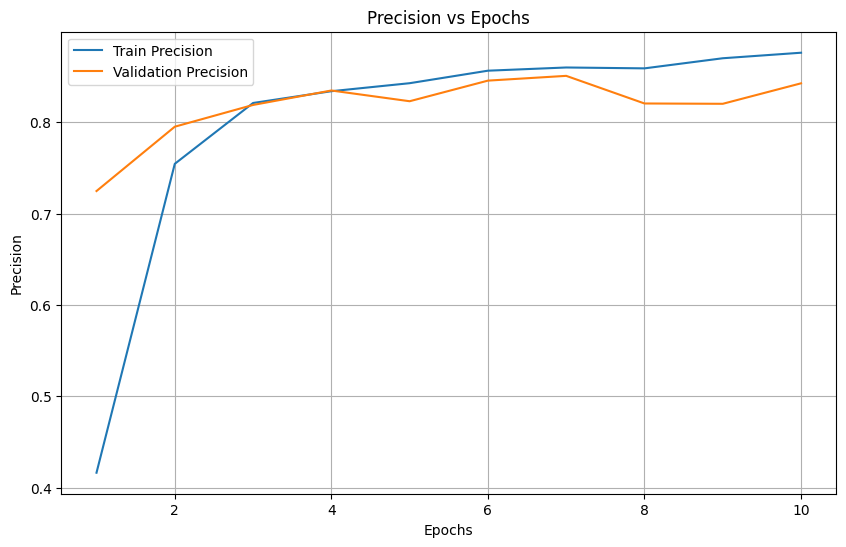

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones (si existen)
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        # Definir la red convolucional
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling con tamaño 2
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adaptar a las dimensiones de la imagen
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Propagar hacia adelante
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Aplanar la salida para las capas densas
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Definir el proceso de entrenamiento ------------------- #
# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar
])

# Cargar los datasets
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Obtener las etiquetas de todos los elementos
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]

# ------------------- Muestreo estratificado ------------------- #
# Obtener el 10% de los datos manteniendo el balance de clases en el conjunto de entrenamiento
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=train_labels)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=val_labels)

# Crear los subconjuntos
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Crear los dataloaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()  # Usamos la entropía cruzada para clasificación
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Métricas por época
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # Calcular métricas para entrenamiento
        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        # Evaluación en el conjunto de validación
        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Graficar métricas
    plot_metrics(metrics)

# Función de evaluación
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# Función para graficar métricas
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics['val_precision'], label='Validation Precision')
    plt.title('Precision vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------- Ejecutar el entrenamiento ------------------- #
# Inicializar el modelo
model = CNNModel(num_classes=15)

# Entrenar el modelo
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.0001)


### Experimento III:

Modificando kernel_size = 5

Epoch 1/10, Train Loss: 1.5063, Train Accuracy: 55.14%, Validation Loss: 0.6407, Validation Accuracy: 82.84%
Epoch 2/10, Train Loss: 0.6430, Train Accuracy: 82.00%, Validation Loss: 0.5461, Validation Accuracy: 86.80%
Epoch 3/10, Train Loss: 0.4963, Train Accuracy: 86.19%, Validation Loss: 0.5266, Validation Accuracy: 86.47%
Epoch 4/10, Train Loss: 0.4513, Train Accuracy: 86.38%, Validation Loss: 0.5219, Validation Accuracy: 85.48%
Epoch 5/10, Train Loss: 0.4130, Train Accuracy: 87.04%, Validation Loss: 0.5304, Validation Accuracy: 82.84%
Epoch 6/10, Train Loss: 0.3523, Train Accuracy: 87.75%, Validation Loss: 0.4709, Validation Accuracy: 85.81%
Epoch 7/10, Train Loss: 0.3067, Train Accuracy: 89.16%, Validation Loss: 0.5110, Validation Accuracy: 85.48%
Epoch 8/10, Train Loss: 0.2890, Train Accuracy: 88.93%, Validation Loss: 0.4994, Validation Accuracy: 83.83%
Epoch 9/10, Train Loss: 0.2703, Train Accuracy: 90.81%, Validation Loss: 0.5669, Validation Accuracy: 84.82%
Epoch 10/10, Train 

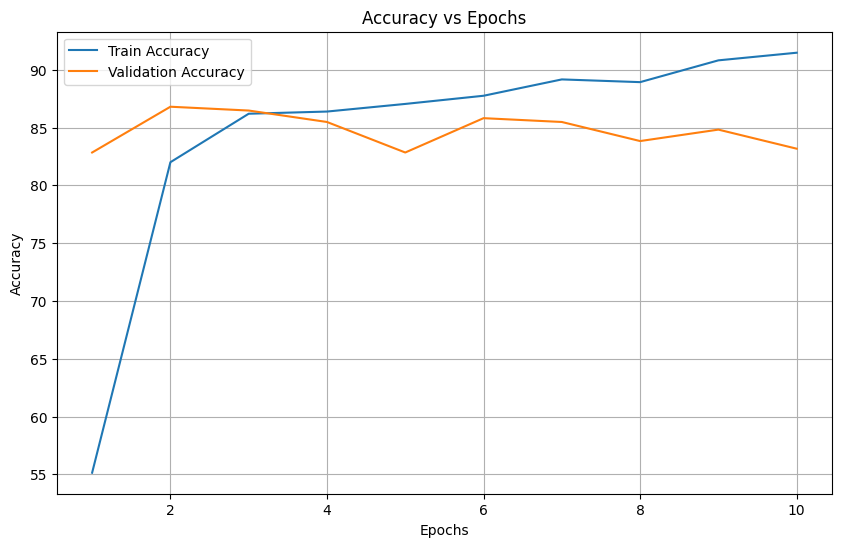

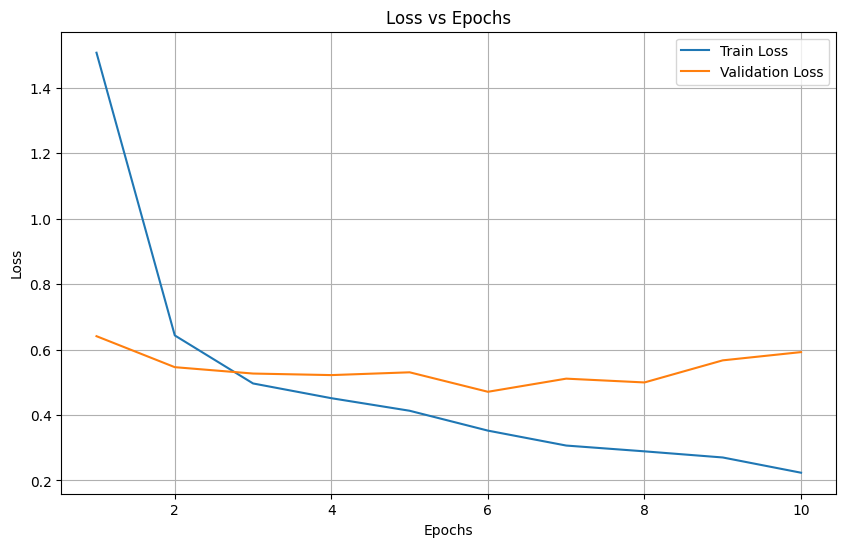

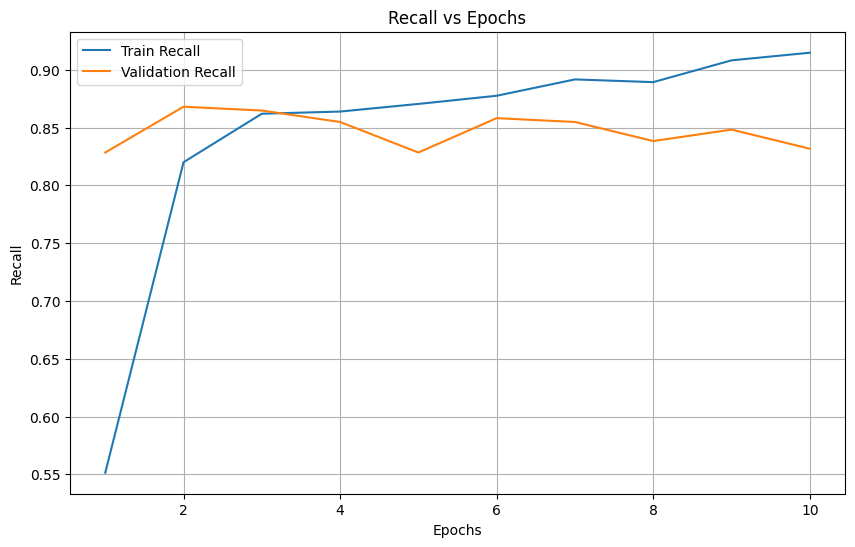

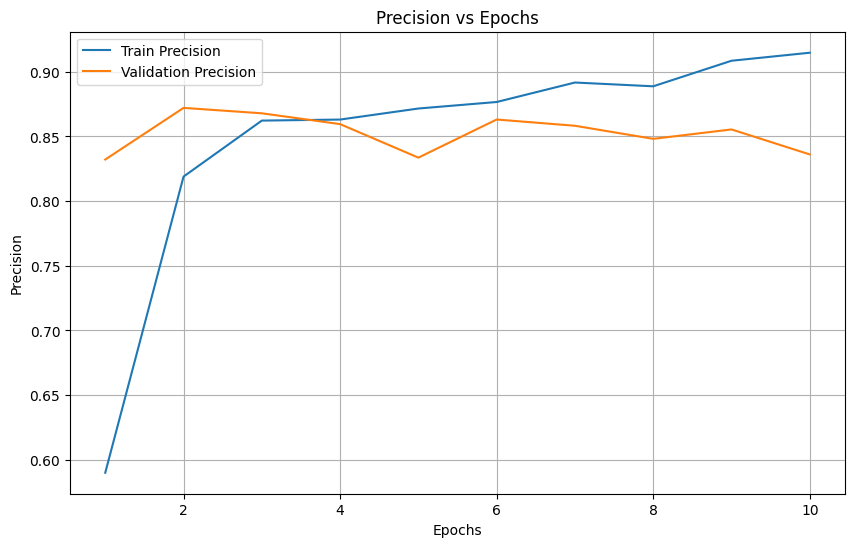

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones (si existen)
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        # Definir la red convolucional con kernel_size = 5
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Cambiar kernel_size a 5
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # Cambiar kernel_size a 5
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)  # Cambiar kernel_size a 5
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling con tamaño 2
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adaptar a las dimensiones de la imagen
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Propagar hacia adelante
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Aplanar la salida para las capas densas
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Definir el proceso de entrenamiento ------------------- #
# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar
])

# Cargar los datasets completos
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Obtener un 10% balanceado de los conjuntos de entrenamiento y validación
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=[label for _, label in train_dataset], random_state=42)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=[label for _, label in val_dataset], random_state=42)

# Crear subconjuntos balanceados
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Crear los dataloaders para los subconjuntos
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()  # Usamos la entropía cruzada para clasificación
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Métricas por época
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # Calcular métricas para entrenamiento
        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        # Evaluación en el conjunto de validación
        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Graficar métricas
    plot_metrics(metrics)

# Función de evaluación
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# Función para graficar métricas
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Recall
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics['val_recall'], label='Validation Recall')
    plt.title('Recall vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics['val_precision'], label='Validation Precision')
    plt.title('Precision vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------- Ejecutar el modelo ------------------- #
# Crear el modelo y entrenarlo
model = CNNModel(num_classes=15)
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)


### Experimento IV:

Modificando kernel_size = 9

Epoch 1/10, Train Loss: 1.6761, Train Accuracy: 48.68%, Validation Loss: 0.6942, Validation Accuracy: 79.54%
Epoch 2/10, Train Loss: 0.6484, Train Accuracy: 81.90%, Validation Loss: 0.5183, Validation Accuracy: 84.49%
Epoch 3/10, Train Loss: 0.5163, Train Accuracy: 84.59%, Validation Loss: 0.4859, Validation Accuracy: 88.45%
Epoch 4/10, Train Loss: 0.4400, Train Accuracy: 86.05%, Validation Loss: 0.5031, Validation Accuracy: 84.82%
Epoch 5/10, Train Loss: 0.3922, Train Accuracy: 86.19%, Validation Loss: 0.5258, Validation Accuracy: 85.81%
Epoch 6/10, Train Loss: 0.3762, Train Accuracy: 87.75%, Validation Loss: 0.5426, Validation Accuracy: 82.18%
Epoch 7/10, Train Loss: 0.3295, Train Accuracy: 88.45%, Validation Loss: 0.5788, Validation Accuracy: 84.49%
Epoch 8/10, Train Loss: 0.3034, Train Accuracy: 88.60%, Validation Loss: 0.5501, Validation Accuracy: 84.16%
Epoch 9/10, Train Loss: 0.2776, Train Accuracy: 90.01%, Validation Loss: 0.5348, Validation Accuracy: 83.50%
Epoch 10/10, Train 

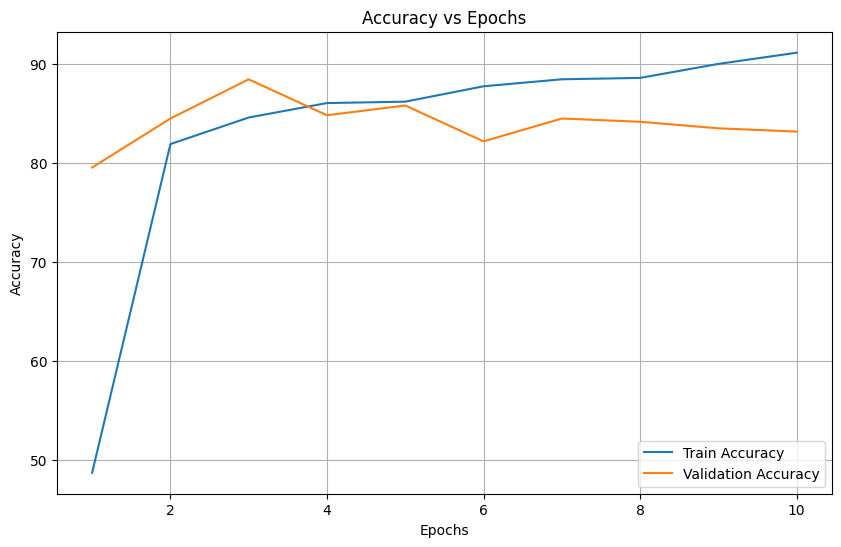

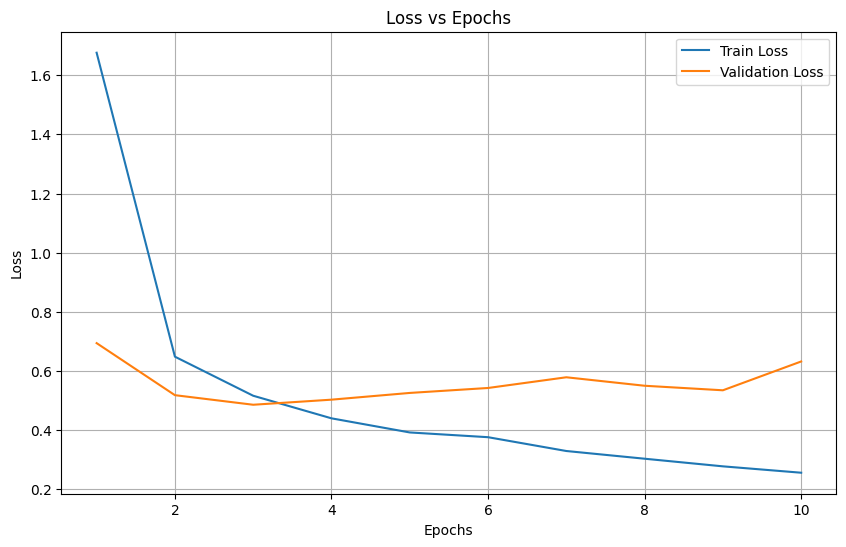

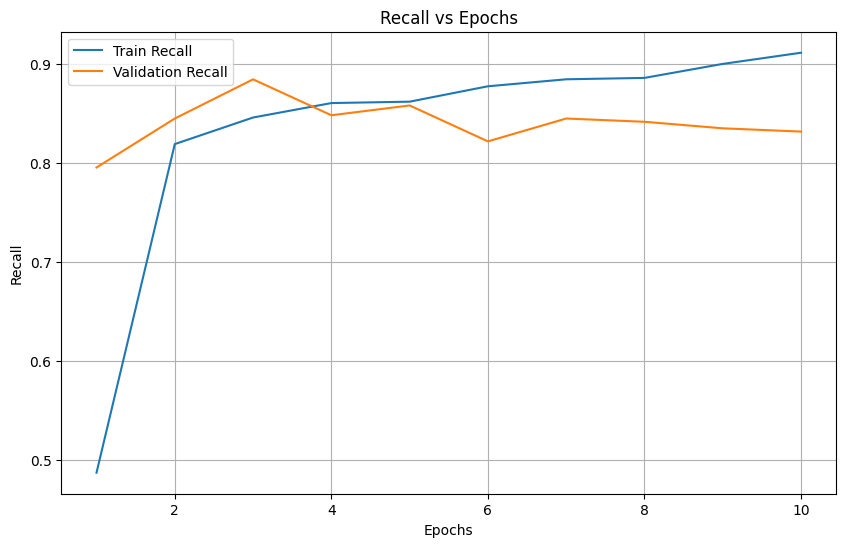

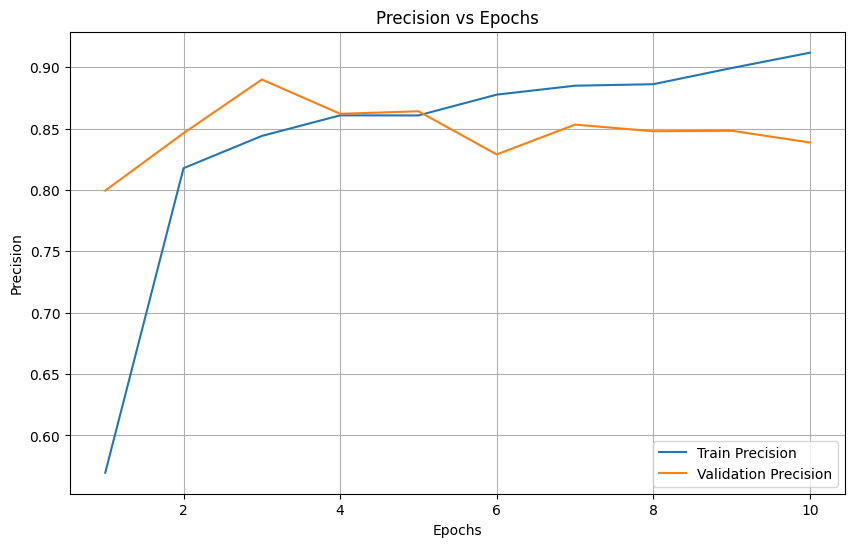

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones (si existen)
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        # Definir la red convolucional con kernel_size = 9
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, padding=4)  # Cambiar kernel_size a 9
        self.conv2 = nn.Conv2d(32, 64, kernel_size=9, padding=4)  # Cambiar kernel_size a 9
        self.conv3 = nn.Conv2d(64, 128, kernel_size=9, padding=4)  # Cambiar kernel_size a 9
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling con tamaño 2
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adaptar a las dimensiones de la imagen
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Propagar hacia adelante
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Aplanar la salida para las capas densas
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Definir el proceso de entrenamiento ------------------- #
# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar
])

# Cargar los datasets completos
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Obtener un 10% balanceado de los conjuntos de entrenamiento y validación
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=[label for _, label in train_dataset], random_state=42)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=[label for _, label in val_dataset], random_state=42)

# Crear subconjuntos balanceados
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Crear los dataloaders para los subconjuntos
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()  # Usamos la entropía cruzada para clasificación
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Métricas por época
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # Calcular métricas para entrenamiento
        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        # Evaluación en el conjunto de validación
        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Graficar métricas
    plot_metrics(metrics)

# Función de evaluación
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# Función para graficar métricas
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Recall
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics['val_recall'], label='Validation Recall')
    plt.title('Recall vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics['val_precision'], label='Validation Precision')
    plt.title('Precision vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------- Ejecutar el modelo ------------------- #
# Crear el modelo y entrenarlo
model = CNNModel(num_classes=15)
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)


### Experimento V:

Modificando batch_size = 64

Epoch 1/10, Train Loss: 2.0682, Train Accuracy: 33.03%, Validation Loss: 0.9409, Validation Accuracy: 71.95%
Epoch 2/10, Train Loss: 0.7306, Train Accuracy: 78.46%, Validation Loss: 0.5885, Validation Accuracy: 83.83%
Epoch 3/10, Train Loss: 0.5423, Train Accuracy: 84.87%, Validation Loss: 0.4992, Validation Accuracy: 85.48%
Epoch 4/10, Train Loss: 0.4859, Train Accuracy: 85.96%, Validation Loss: 0.5391, Validation Accuracy: 82.51%
Epoch 5/10, Train Loss: 0.4391, Train Accuracy: 86.66%, Validation Loss: 0.4583, Validation Accuracy: 87.13%
Epoch 6/10, Train Loss: 0.3711, Train Accuracy: 87.70%, Validation Loss: 0.4839, Validation Accuracy: 84.82%
Epoch 7/10, Train Loss: 0.3335, Train Accuracy: 88.08%, Validation Loss: 0.5433, Validation Accuracy: 83.17%
Epoch 8/10, Train Loss: 0.2826, Train Accuracy: 89.77%, Validation Loss: 0.5282, Validation Accuracy: 86.47%
Epoch 9/10, Train Loss: 0.2636, Train Accuracy: 90.43%, Validation Loss: 0.5182, Validation Accuracy: 87.46%
Epoch 10/10, Train 

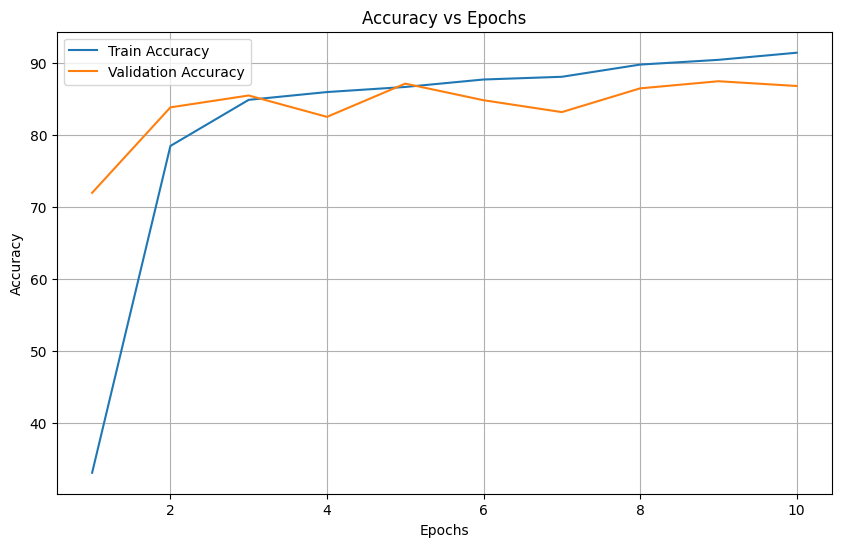

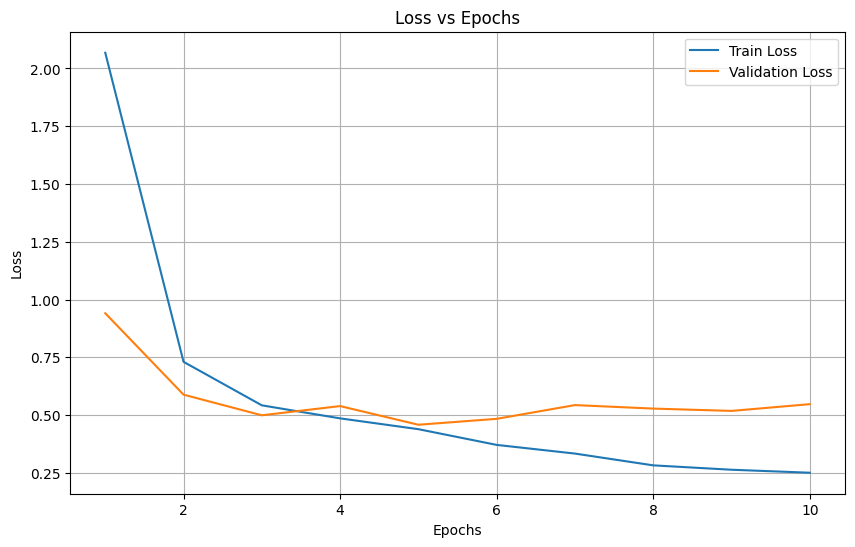

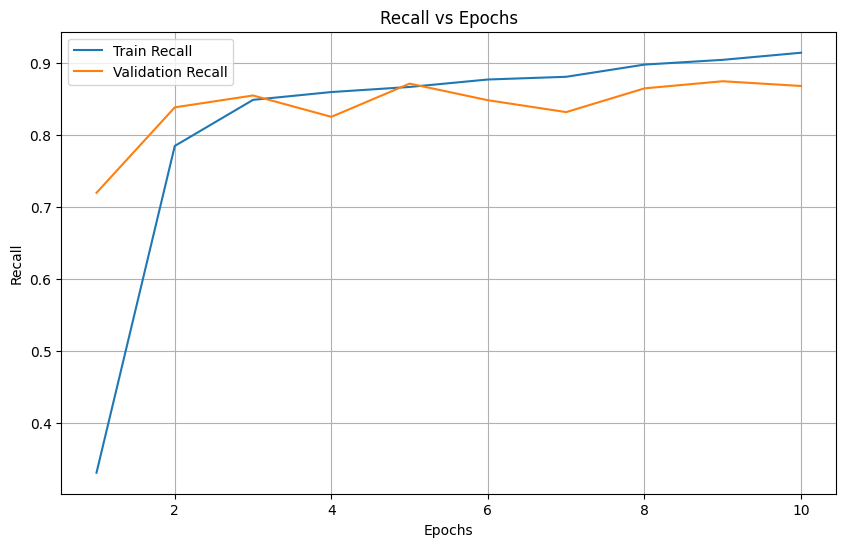

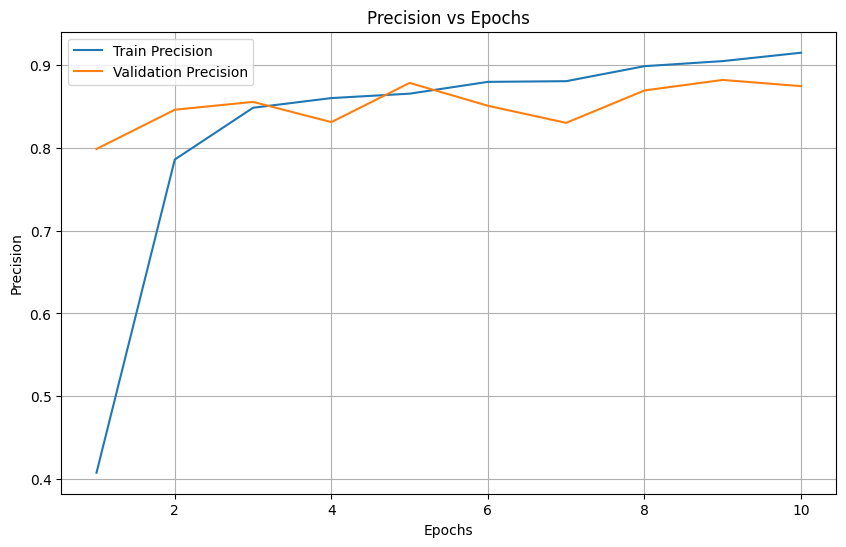

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones (si existen)
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        # Definir la red convolucional con kernel_size = 9
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, padding=4)  # Cambiar kernel_size a 9
        self.conv2 = nn.Conv2d(32, 64, kernel_size=9, padding=4)  # Cambiar kernel_size a 9
        self.conv3 = nn.Conv2d(64, 128, kernel_size=9, padding=4)  # Cambiar kernel_size a 9
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling con tamaño 2
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adaptar a las dimensiones de la imagen
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Propagar hacia adelante
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Aplanar la salida para las capas densas
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Definir el proceso de entrenamiento ------------------- #
# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar
])

# Cargar los datasets completos
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Obtener un 10% balanceado de los conjuntos de entrenamiento y validación
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=[label for _, label in train_dataset], random_state=42)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=[label for _, label in val_dataset], random_state=42)

# Crear subconjuntos balanceados
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Crear los dataloaders para los subconjuntos
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)  # Cambiar batch_size a 64
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)  # Cambiar batch_size a 64

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()  # Usamos la entropía cruzada para clasificación
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Métricas por época
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # Calcular métricas para entrenamiento
        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        # Evaluación en el conjunto de validación
        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Graficar métricas
    plot_metrics(metrics)

# Función de evaluación
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# Función para graficar métricas
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Recall
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics['val_recall'], label='Validation Recall')
    plt.title('Recall vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics['val_precision'], label='Validation Precision')
    plt.title('Precision vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------- Ejecutar el modelo ------------------- #
# Crear el modelo y entrenarlo
model = CNNModel(num_classes=15)
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)


### Experimento VI:

Modificando batch_size = 128

Epoch 1/10, Train Loss: 2.8017, Train Accuracy: 8.39%, Validation Loss: 2.7017, Validation Accuracy: 9.90%
Epoch 2/10, Train Loss: 2.7005, Train Accuracy: 8.86%, Validation Loss: 2.6824, Validation Accuracy: 9.90%
Epoch 3/10, Train Loss: 2.6981, Train Accuracy: 8.77%, Validation Loss: 2.6895, Validation Accuracy: 9.90%
Epoch 4/10, Train Loss: 2.6906, Train Accuracy: 9.28%, Validation Loss: 2.6491, Validation Accuracy: 10.23%
Epoch 5/10, Train Loss: 2.5932, Train Accuracy: 13.90%, Validation Loss: 2.4287, Validation Accuracy: 19.47%
Epoch 6/10, Train Loss: 2.4560, Train Accuracy: 17.15%, Validation Loss: 2.3376, Validation Accuracy: 22.44%
Epoch 7/10, Train Loss: 2.2041, Train Accuracy: 25.64%, Validation Loss: 1.9092, Validation Accuracy: 34.32%
Epoch 8/10, Train Loss: 1.8192, Train Accuracy: 38.69%, Validation Loss: 1.5169, Validation Accuracy: 47.85%
Epoch 9/10, Train Loss: 1.2509, Train Accuracy: 60.27%, Validation Loss: 0.6438, Validation Accuracy: 78.55%
Epoch 10/10, Train Loss: 0

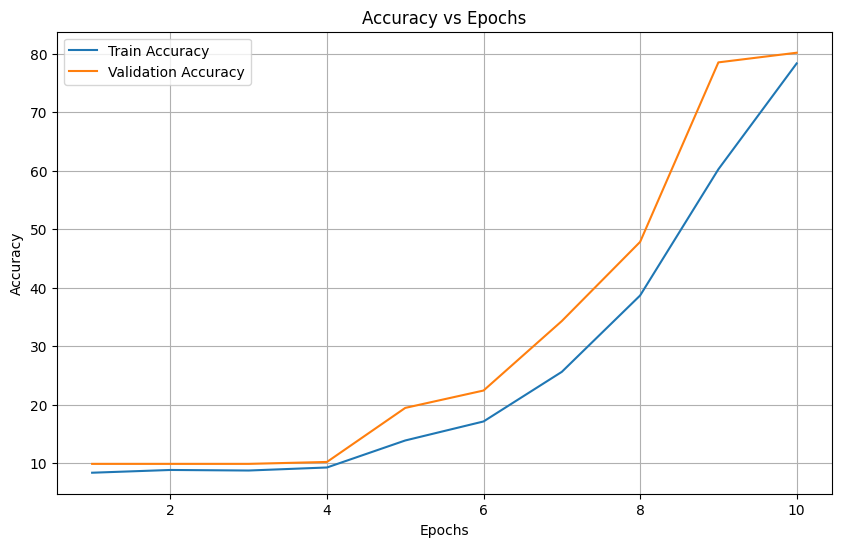

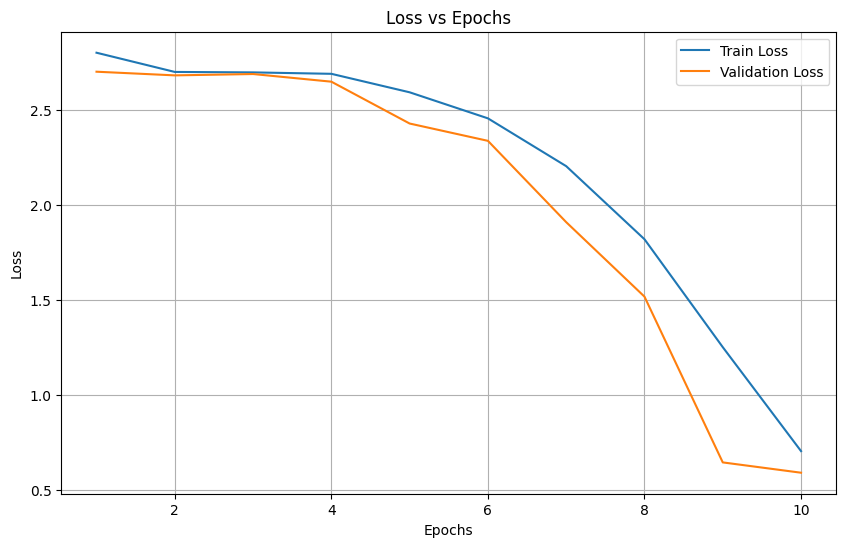

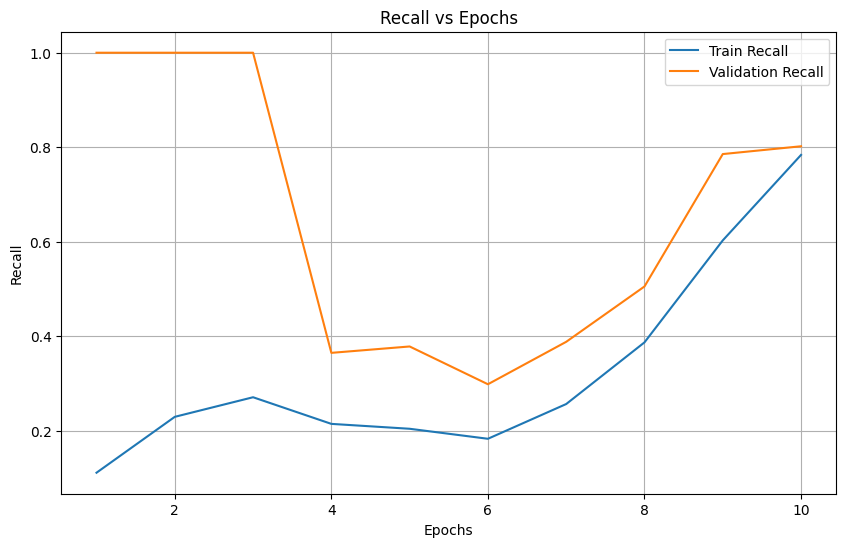

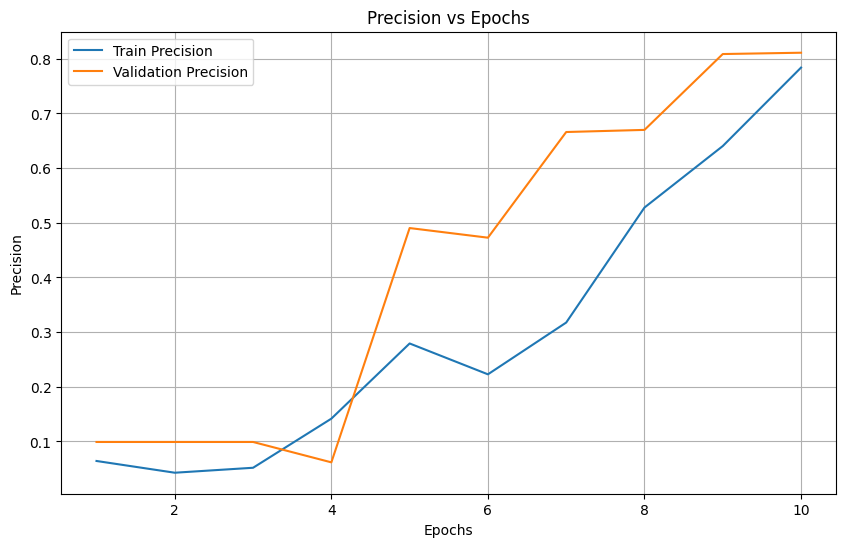

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones (si existen)
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        # Definir la red convolucional con kernel_size = 9
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, padding=4)  # Cambiar kernel_size a 9
        self.conv2 = nn.Conv2d(32, 64, kernel_size=9, padding=4)  # Cambiar kernel_size a 9
        self.conv3 = nn.Conv2d(64, 128, kernel_size=9, padding=4)  # Cambiar kernel_size a 9
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling con tamaño 2
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adaptar a las dimensiones de la imagen
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Propagar hacia adelante
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Aplanar la salida para las capas densas
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Definir el proceso de entrenamiento ------------------- #
# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar
])

# Cargar los datasets completos
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Obtener un 10% balanceado de los conjuntos de entrenamiento y validación
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=[label for _, label in train_dataset], random_state=42)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=[label for _, label in val_dataset], random_state=42)

# Crear subconjuntos balanceados
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Crear los dataloaders para los subconjuntos
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)  # Cambiar batch_size a 128
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)  # Cambiar batch_size a 128

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()  # Usamos la entropía cruzada para clasificación
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Métricas por época
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # Calcular métricas para entrenamiento
        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        # Evaluación en el conjunto de validación
        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Graficar métricas
    plot_metrics(metrics)

# Función de evaluación
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# Función para graficar métricas
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Recall
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics['val_recall'], label='Validation Recall')
    plt.title('Recall vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics['val_precision'], label='Validation Precision')
    plt.title('Precision vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------- Ejecutar el modelo ------------------- #
# Crear el modelo y entrenarlo
model = CNNModel(num_classes=15)
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)


### Experimento VII:

drop_out = 0.75

Epoch 1/10, Train Loss: 2.8784, Train Accuracy: 6.79%, Validation Loss: 2.7039, Validation Accuracy: 9.57%
Epoch 2/10, Train Loss: 2.7068, Train Accuracy: 7.73%, Validation Loss: 2.6970, Validation Accuracy: 9.57%
Epoch 3/10, Train Loss: 2.7036, Train Accuracy: 9.10%, Validation Loss: 2.6898, Validation Accuracy: 9.57%
Epoch 4/10, Train Loss: 2.7005, Train Accuracy: 10.13%, Validation Loss: 2.6855, Validation Accuracy: 9.57%
Epoch 5/10, Train Loss: 2.6985, Train Accuracy: 9.75%, Validation Loss: 2.6891, Validation Accuracy: 9.57%
Epoch 6/10, Train Loss: 2.6996, Train Accuracy: 9.33%, Validation Loss: 2.6869, Validation Accuracy: 9.57%
Epoch 7/10, Train Loss: 2.6986, Train Accuracy: 9.00%, Validation Loss: 2.6859, Validation Accuracy: 9.57%
Epoch 8/10, Train Loss: 2.6978, Train Accuracy: 9.05%, Validation Loss: 2.6839, Validation Accuracy: 9.57%
Epoch 9/10, Train Loss: 2.7000, Train Accuracy: 8.62%, Validation Loss: 2.6886, Validation Accuracy: 9.57%
Epoch 10/10, Train Loss: 2.6997, Tra

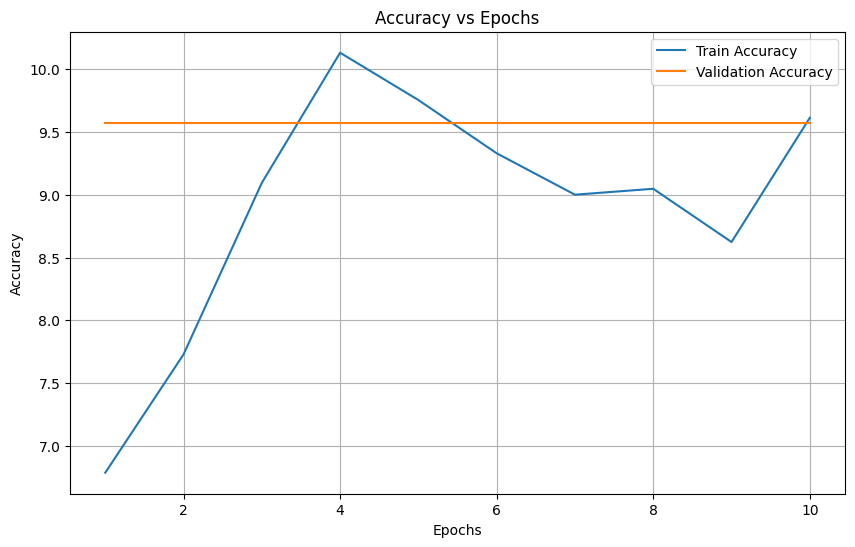

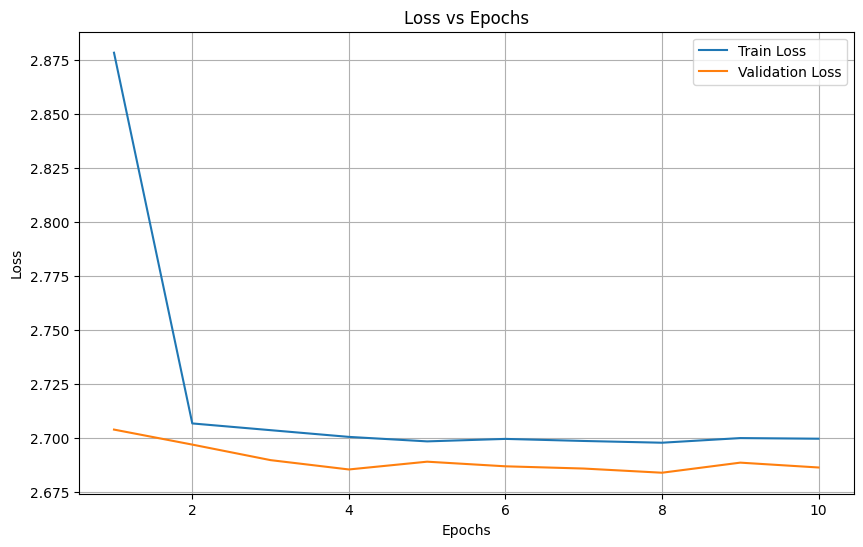

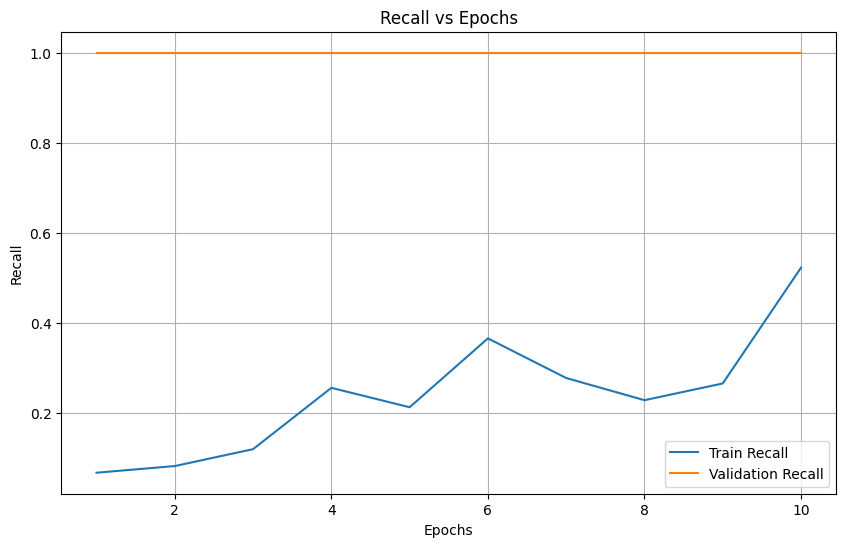

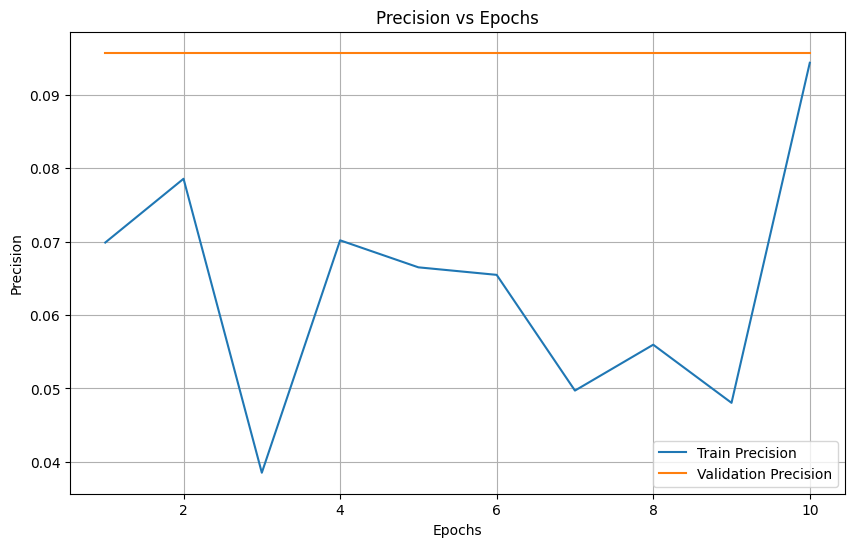

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones (si existen)
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        # Definir la red convolucional con kernel_size = 9
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=9, padding=4)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=9, padding=4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.75)  # Cambiado a 0.75

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Definir el proceso de entrenamiento ------------------- #
# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Cargar los datasets completos
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Obtener un 10% balanceado de los conjuntos de entrenamiento y validación
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=[label for _, label in train_dataset], random_state=42)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=[label for _, label in val_dataset], random_state=42)

# Crear subconjuntos balanceados
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Crear los dataloaders para los subconjuntos
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    plot_metrics(metrics)

# Función de evaluación
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# Función para graficar métricas
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics['val_recall'], label='Validation Recall')
    plt.title('Recall vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics['val_precision'], label='Validation Precision')
    plt.title('Precision vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------- Ejecutar el modelo ------------------- #
model = CNNModel(num_classes=15)
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)

### Experimento VIII:

drop_out = 0.25

Epoch 1/10, Train Loss: 2.4436, Train Accuracy: 29.88%, Validation Loss: 1.0595, Validation Accuracy: 68.98%
Epoch 2/10, Train Loss: 0.8197, Train Accuracy: 77.95%, Validation Loss: 0.5960, Validation Accuracy: 81.85%
Epoch 3/10, Train Loss: 0.5467, Train Accuracy: 84.97%, Validation Loss: 0.5197, Validation Accuracy: 83.83%
Epoch 4/10, Train Loss: 0.4386, Train Accuracy: 85.53%, Validation Loss: 0.4721, Validation Accuracy: 85.48%
Epoch 5/10, Train Loss: 0.3708, Train Accuracy: 88.08%, Validation Loss: 0.4850, Validation Accuracy: 83.83%
Epoch 6/10, Train Loss: 0.3090, Train Accuracy: 89.49%, Validation Loss: 0.4753, Validation Accuracy: 83.50%
Epoch 7/10, Train Loss: 0.2790, Train Accuracy: 90.01%, Validation Loss: 0.5201, Validation Accuracy: 82.18%
Epoch 8/10, Train Loss: 0.2360, Train Accuracy: 91.09%, Validation Loss: 0.5448, Validation Accuracy: 83.50%
Epoch 9/10, Train Loss: 0.2018, Train Accuracy: 92.08%, Validation Loss: 0.5655, Validation Accuracy: 83.83%
Epoch 10/10, Train 

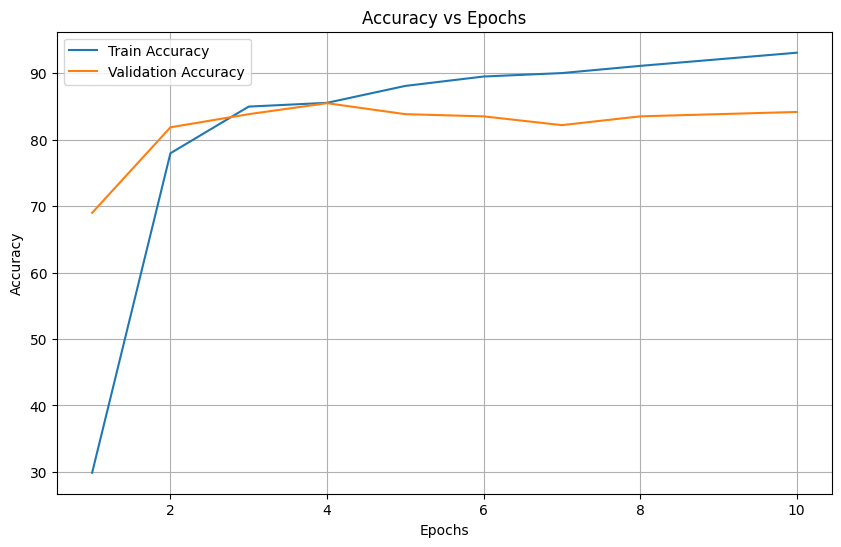

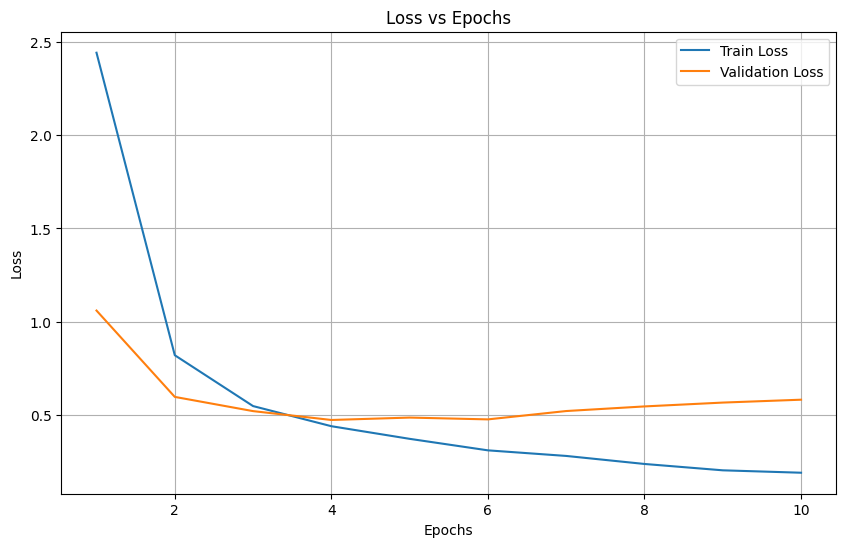

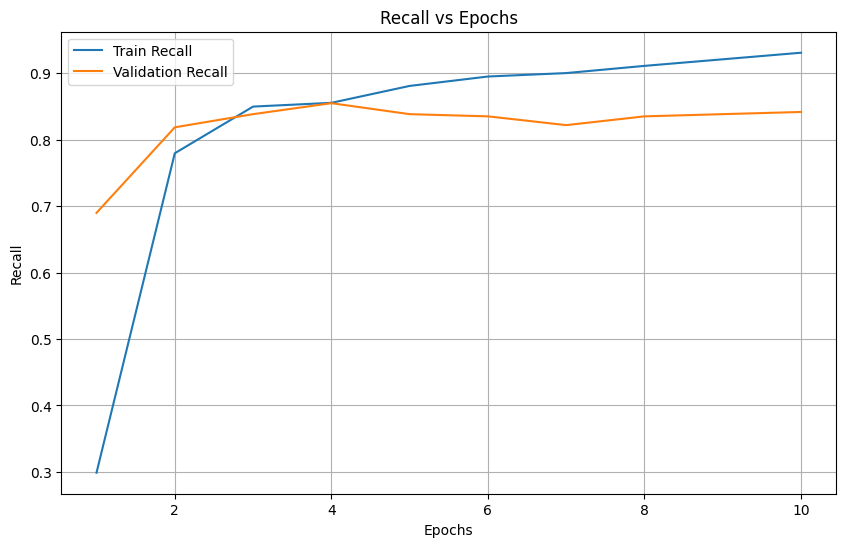

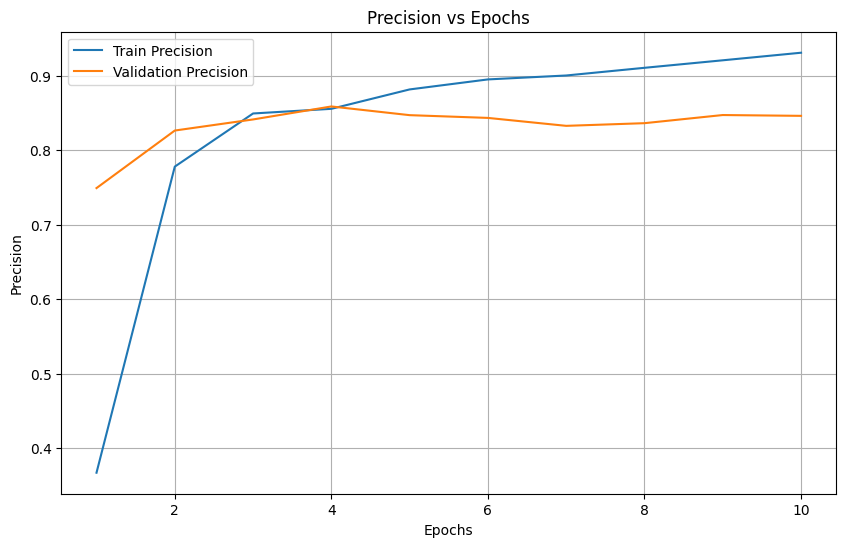

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones (si existen)
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        # Definir la red convolucional con kernel_size = 9
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=9, padding=4)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=9, padding=4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.25)  # Cambiado a 0.25

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Definir el proceso de entrenamiento ------------------- #
# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Cargar los datasets completos
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Obtener un 10% balanceado de los conjuntos de entrenamiento y validación
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=[label for _, label in train_dataset], random_state=42)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=[label for _, label in val_dataset], random_state=42)

# Crear subconjuntos balanceados
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Crear los dataloaders para los subconjuntos
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    plot_metrics(metrics)

# Función de evaluación
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# Función para graficar métricas
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics['val_recall'], label='Validation Recall')
    plt.title('Recall vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics['val_precision'], label='Validation Precision')
    plt.title('Precision vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------- Ejecutar el modelo ------------------- #
model = CNNModel(num_classes=15)
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)


### Experimento IX:

1. learning_rate = 0.001
2. kernel_size = 5
3. batch_size = 64
4. epochs = 10
5. drop_out = 0.5

Epoch 1/10, Train Loss: 1.9163, Train Accuracy: 39.02%, Validation Loss: 0.7915, Validation Accuracy: 80.20%
Epoch 2/10, Train Loss: 0.7241, Train Accuracy: 80.44%, Validation Loss: 0.5397, Validation Accuracy: 84.82%
Epoch 3/10, Train Loss: 0.5111, Train Accuracy: 85.11%, Validation Loss: 0.4732, Validation Accuracy: 88.45%
Epoch 4/10, Train Loss: 0.4437, Train Accuracy: 86.66%, Validation Loss: 0.4808, Validation Accuracy: 87.13%
Epoch 5/10, Train Loss: 0.4007, Train Accuracy: 87.42%, Validation Loss: 0.4603, Validation Accuracy: 86.80%
Epoch 6/10, Train Loss: 0.3688, Train Accuracy: 87.94%, Validation Loss: 0.5057, Validation Accuracy: 84.82%
Epoch 7/10, Train Loss: 0.3144, Train Accuracy: 88.12%, Validation Loss: 0.5014, Validation Accuracy: 87.79%
Epoch 8/10, Train Loss: 0.3125, Train Accuracy: 89.07%, Validation Loss: 0.5098, Validation Accuracy: 85.15%
Epoch 9/10, Train Loss: 0.2929, Train Accuracy: 89.44%, Validation Loss: 0.4702, Validation Accuracy: 84.16%
Epoch 10/10, Train 

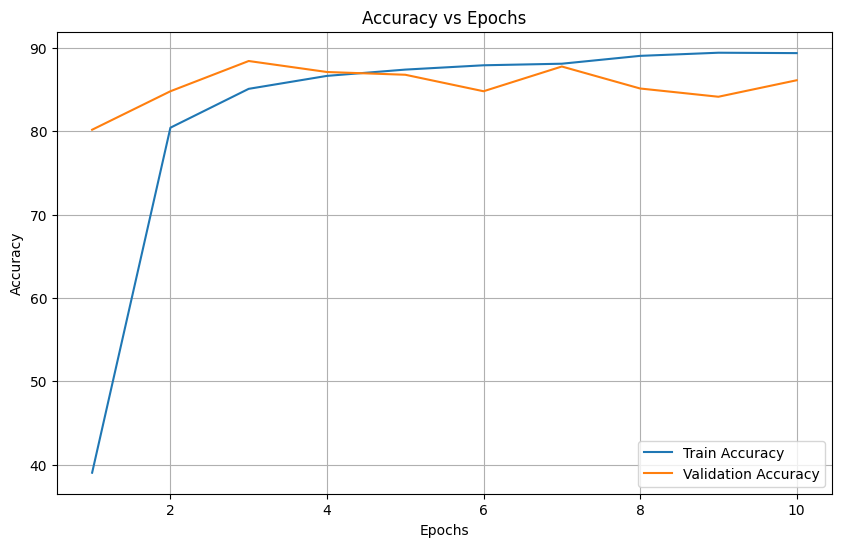

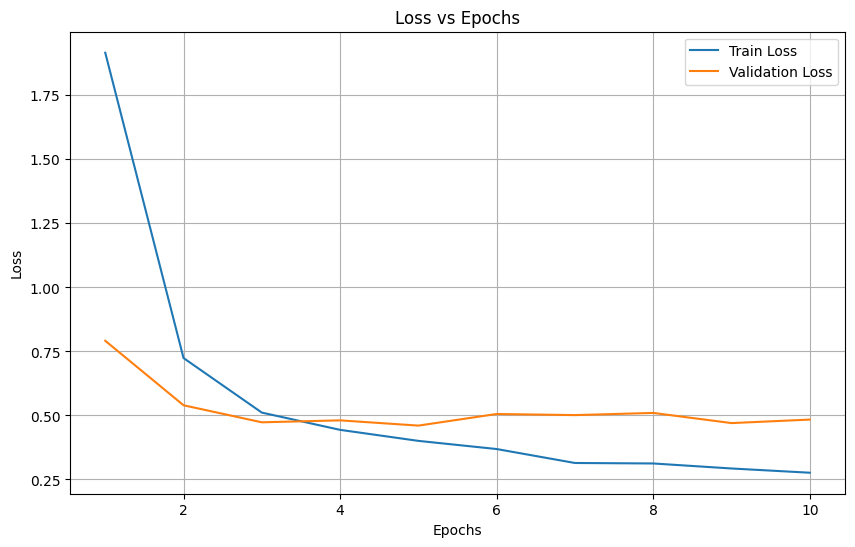

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        # Actualizado kernel_size a 5
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)  # Actualizado a 0.5

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Configuración del entrenamiento ------------------- #
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Cargar los datasets
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Crear subconjuntos balanceados
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=[label for _, label in train_dataset], random_state=42)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=[label for _, label in val_dataset], random_state=42)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# Dataloaders con batch_size = 64
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    plot_metrics(metrics)

# ------------------- Función de evaluación ------------------- #
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# ------------------- Graficar métricas ------------------- #
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------- Ejecutar el modelo ------------------- #
model = CNNModel(num_classes=15)
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)

### Observaciones:

A partir de los experimentos previos, se resume a continuación los resultados en la siguiente tabla:

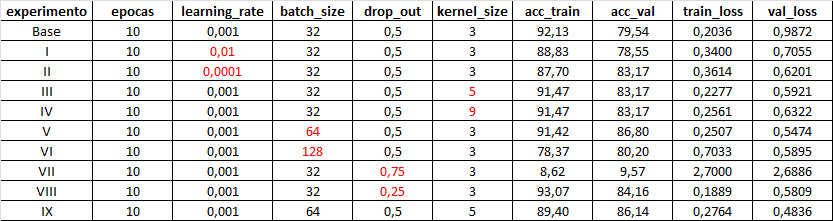

Los valores mostrados de pérdida y métrica corresponden al valor al cual *tienden* hacia el final del entrenamiento. No obstante, hay que tener en cuenta que para identificar subajuste o sobreajuste es necesario visualizar las curvas completas graficadas.

A partir de lo anterior, se identificó una región de interés del espacio de hiperparámetros dada por:

|hiperparámetro|valor           |
|--------------|----------------|
|learning rate | 0.0015 a 0.0005|
|batch size    | 76 a 52        |
|drop out      | 0.3 a 0.1      |

Con lo cual, a continuación, se intentó hilar más fino en la búsqueda de de hiperparámetros con un *Grid Search* dado por estos valores.

### Experimento X (Grid Search en Mala fina):
A partir de los resultados de los experimentos previos, se define una grilla fina de hiperparámetros.

In [ ]:
# Define la gilla fina de hiperparámetros
learning_rates = [0.0015, 0.0005]
batch_sizes = [76, 52]
drop_outs = [0.3, 0.1]
kernel_size = 5
num_epochs = 10

Experimento con: learning rate = 0.0015, batch size = 76, Drop Out = 0.3
Epoch 1/10, Train Loss: 1.8281, Train Accuracy: 43.73%, Validation Loss: 0.8606, Validation Accuracy: 76.57%
Epoch 2/10, Train Loss: 0.6660, Train Accuracy: 82.09%, Validation Loss: 0.5882, Validation Accuracy: 84.82%
Epoch 3/10, Train Loss: 0.4836, Train Accuracy: 85.96%, Validation Loss: 0.5445, Validation Accuracy: 84.82%
Epoch 4/10, Train Loss: 0.3882, Train Accuracy: 86.95%, Validation Loss: 0.5273, Validation Accuracy: 86.14%
Epoch 5/10, Train Loss: 0.3496, Train Accuracy: 88.27%, Validation Loss: 0.5014, Validation Accuracy: 85.48%
Epoch 6/10, Train Loss: 0.2851, Train Accuracy: 89.49%, Validation Loss: 0.6116, Validation Accuracy: 83.17%
Epoch 7/10, Train Loss: 0.2715, Train Accuracy: 89.77%, Validation Loss: 0.5659, Validation Accuracy: 83.83%
Epoch 8/10, Train Loss: 0.2324, Train Accuracy: 91.52%, Validation Loss: 0.5347, Validation Accuracy: 85.81%
Epoch 9/10, Train Loss: 0.2042, Train Accuracy: 92.46%,

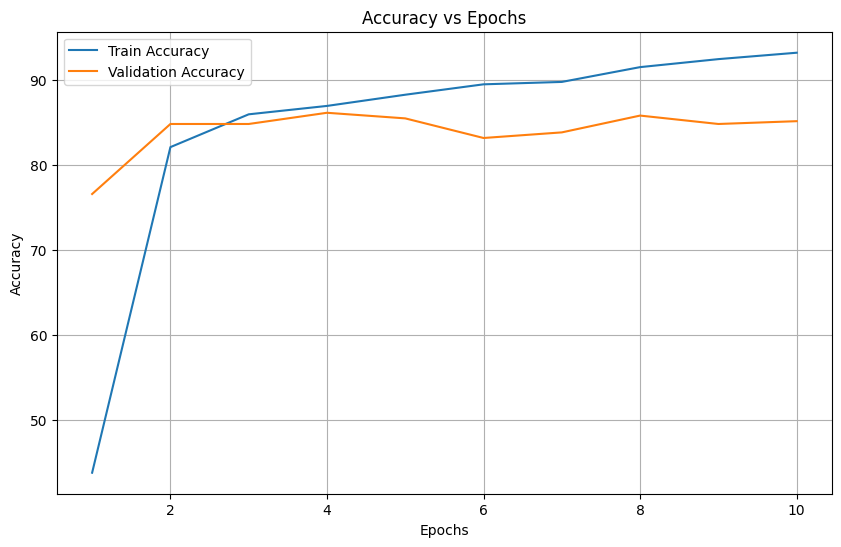

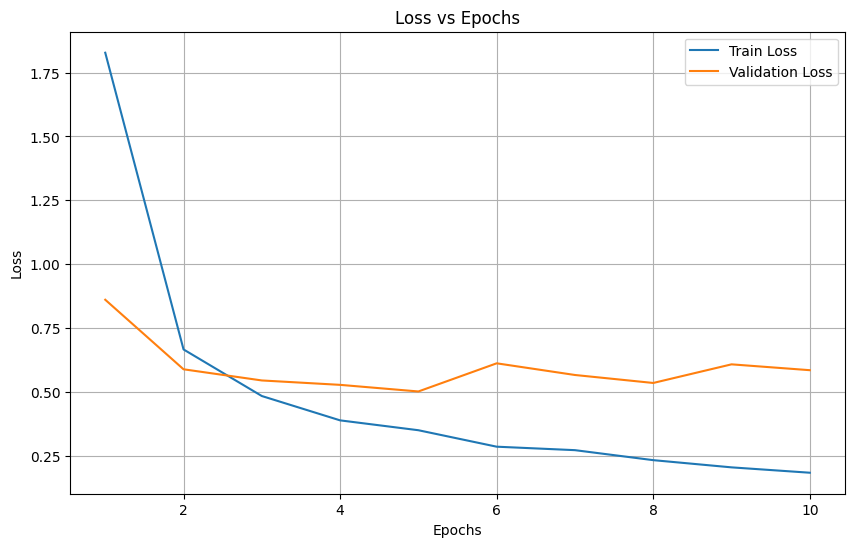

Experimento con: learning rate = 0.0015, batch size = 76, Drop Out = 0.1
Epoch 1/10, Train Loss: 1.7758, Train Accuracy: 46.75%, Validation Loss: 0.9761, Validation Accuracy: 72.94%
Epoch 2/10, Train Loss: 0.6480, Train Accuracy: 82.75%, Validation Loss: 0.6036, Validation Accuracy: 83.17%
Epoch 3/10, Train Loss: 0.4561, Train Accuracy: 86.38%, Validation Loss: 0.5192, Validation Accuracy: 85.15%
Epoch 4/10, Train Loss: 0.3529, Train Accuracy: 87.46%, Validation Loss: 0.5639, Validation Accuracy: 84.49%
Epoch 5/10, Train Loss: 0.3175, Train Accuracy: 88.74%, Validation Loss: 0.5539, Validation Accuracy: 84.49%
Epoch 6/10, Train Loss: 0.2637, Train Accuracy: 90.15%, Validation Loss: 0.5135, Validation Accuracy: 86.47%
Epoch 7/10, Train Loss: 0.2426, Train Accuracy: 91.00%, Validation Loss: 0.6194, Validation Accuracy: 83.17%
Epoch 8/10, Train Loss: 0.2135, Train Accuracy: 92.70%, Validation Loss: 0.6147, Validation Accuracy: 86.14%
Epoch 9/10, Train Loss: 0.1794, Train Accuracy: 92.79%,

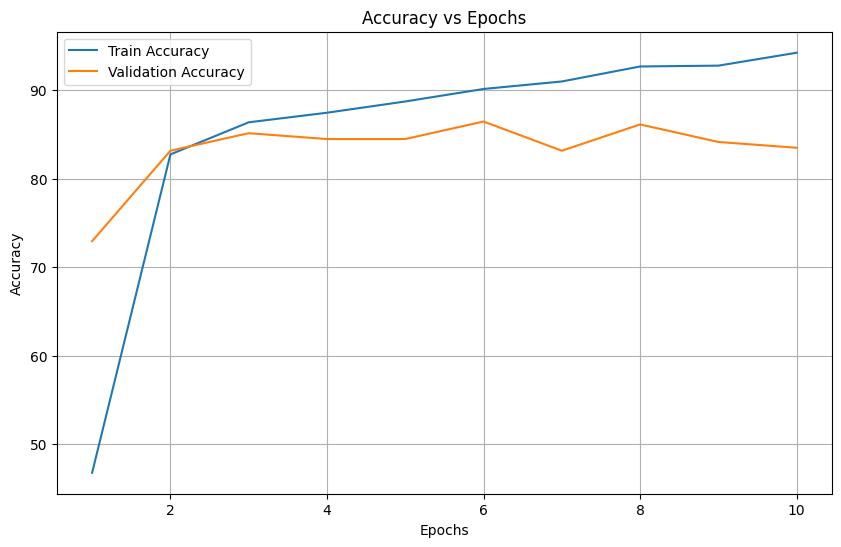

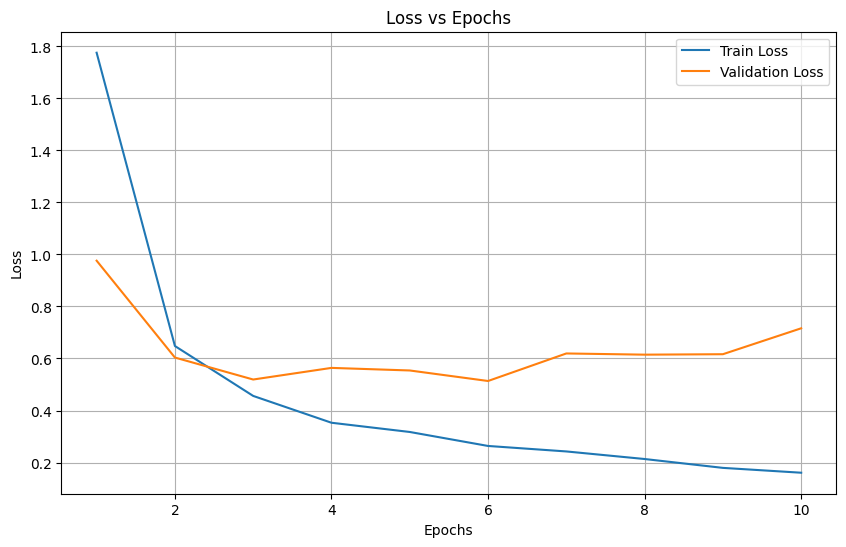

Experimento con: learning rate = 0.0015, batch size = 52, Drop Out = 0.3
Epoch 1/10, Train Loss: 1.9320, Train Accuracy: 43.21%, Validation Loss: 0.7753, Validation Accuracy: 80.20%
Epoch 2/10, Train Loss: 0.5918, Train Accuracy: 83.03%, Validation Loss: 0.5471, Validation Accuracy: 85.81%
Epoch 3/10, Train Loss: 0.4654, Train Accuracy: 86.05%, Validation Loss: 0.5591, Validation Accuracy: 85.15%
Epoch 4/10, Train Loss: 0.4171, Train Accuracy: 87.18%, Validation Loss: 0.5249, Validation Accuracy: 84.16%
Epoch 5/10, Train Loss: 0.3619, Train Accuracy: 87.98%, Validation Loss: 0.5155, Validation Accuracy: 85.15%
Epoch 6/10, Train Loss: 0.3037, Train Accuracy: 89.21%, Validation Loss: 0.5403, Validation Accuracy: 85.48%
Epoch 7/10, Train Loss: 0.2736, Train Accuracy: 90.43%, Validation Loss: 0.4897, Validation Accuracy: 84.16%
Epoch 8/10, Train Loss: 0.2394, Train Accuracy: 91.52%, Validation Loss: 0.5189, Validation Accuracy: 84.82%
Epoch 9/10, Train Loss: 0.2174, Train Accuracy: 92.13%,

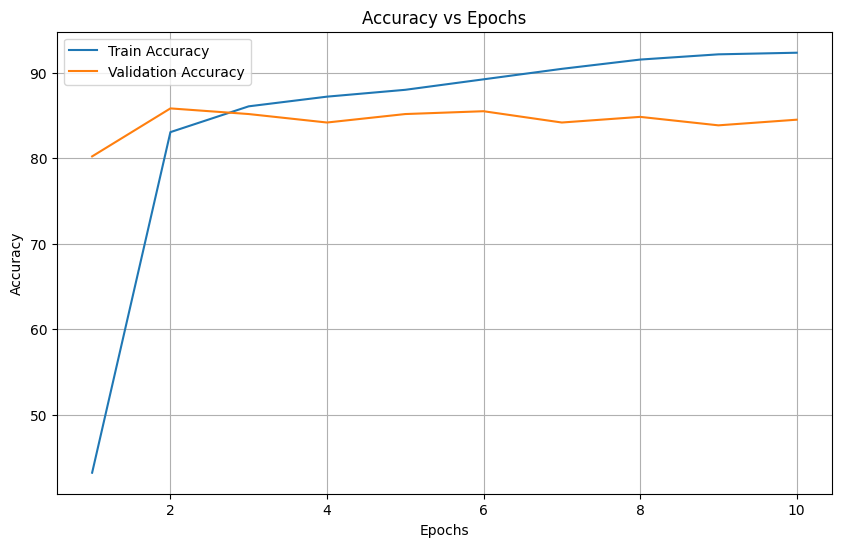

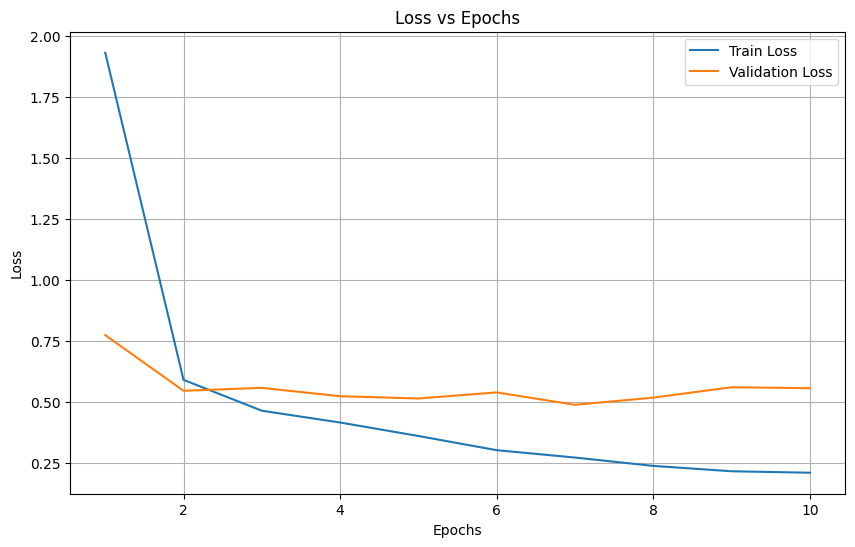

Experimento con: learning rate = 0.0015, batch size = 52, Drop Out = 0.1
Epoch 1/10, Train Loss: 1.6084, Train Accuracy: 53.58%, Validation Loss: 0.7798, Validation Accuracy: 75.25%
Epoch 2/10, Train Loss: 0.5876, Train Accuracy: 83.03%, Validation Loss: 0.6320, Validation Accuracy: 81.19%
Epoch 3/10, Train Loss: 0.4515, Train Accuracy: 85.82%, Validation Loss: 0.4961, Validation Accuracy: 85.81%
Epoch 4/10, Train Loss: 0.3534, Train Accuracy: 87.37%, Validation Loss: 0.5211, Validation Accuracy: 84.82%
Epoch 5/10, Train Loss: 0.3285, Train Accuracy: 88.22%, Validation Loss: 0.5467, Validation Accuracy: 86.80%
Epoch 6/10, Train Loss: 0.2599, Train Accuracy: 89.77%, Validation Loss: 0.5180, Validation Accuracy: 85.48%
Epoch 7/10, Train Loss: 0.2570, Train Accuracy: 90.53%, Validation Loss: 0.5346, Validation Accuracy: 86.80%
Epoch 8/10, Train Loss: 0.2119, Train Accuracy: 92.22%, Validation Loss: 0.5853, Validation Accuracy: 85.15%
Epoch 9/10, Train Loss: 0.1861, Train Accuracy: 92.93%,

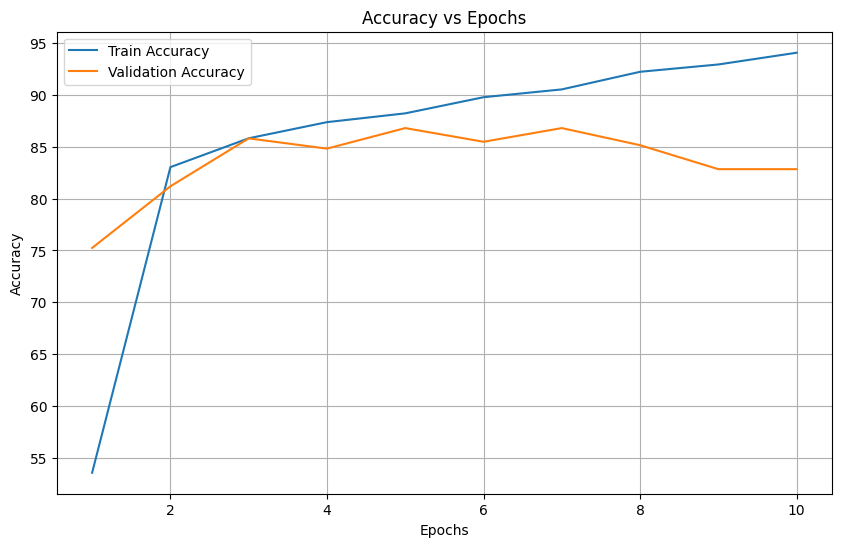

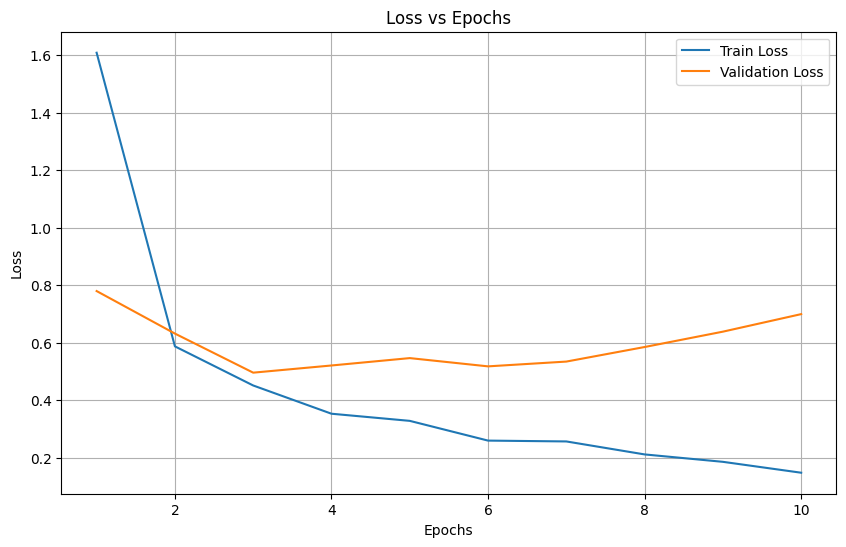

Experimento con: learning rate = 0.0005, batch size = 76, Drop Out = 0.3
Epoch 1/10, Train Loss: 1.4764, Train Accuracy: 53.16%, Validation Loss: 0.6721, Validation Accuracy: 83.50%
Epoch 2/10, Train Loss: 0.5730, Train Accuracy: 84.40%, Validation Loss: 0.5608, Validation Accuracy: 85.81%
Epoch 3/10, Train Loss: 0.4438, Train Accuracy: 87.42%, Validation Loss: 0.5337, Validation Accuracy: 86.14%
Epoch 4/10, Train Loss: 0.3750, Train Accuracy: 87.37%, Validation Loss: 0.4629, Validation Accuracy: 85.48%
Epoch 5/10, Train Loss: 0.3124, Train Accuracy: 88.78%, Validation Loss: 0.4709, Validation Accuracy: 84.16%
Epoch 6/10, Train Loss: 0.2780, Train Accuracy: 89.59%, Validation Loss: 0.5490, Validation Accuracy: 84.82%
Epoch 7/10, Train Loss: 0.2415, Train Accuracy: 90.76%, Validation Loss: 0.5774, Validation Accuracy: 85.15%
Epoch 8/10, Train Loss: 0.2314, Train Accuracy: 91.56%, Validation Loss: 0.5196, Validation Accuracy: 87.79%
Epoch 9/10, Train Loss: 0.1952, Train Accuracy: 92.65%,

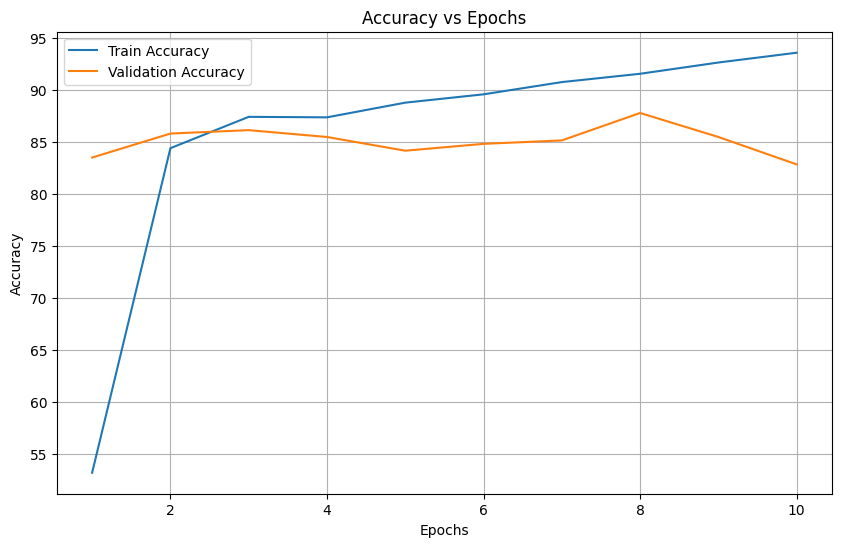

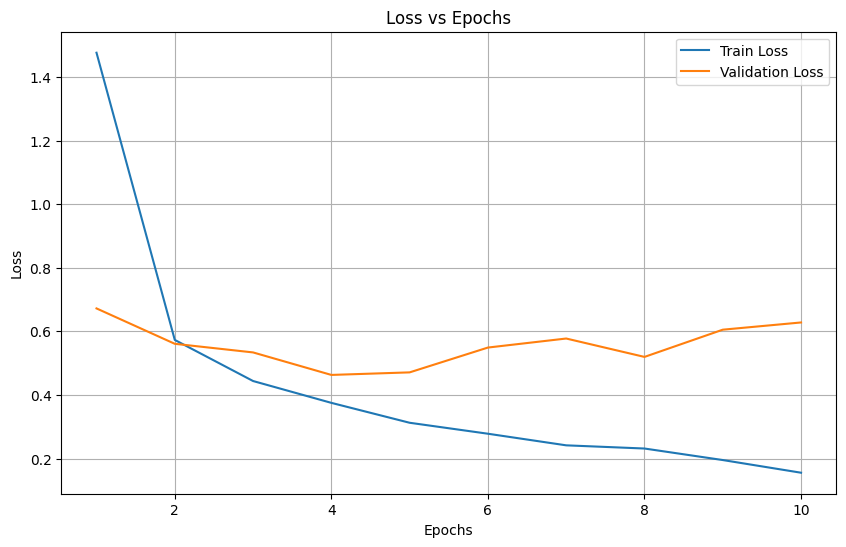

Experimento con: learning rate = 0.0005, batch size = 76, Drop Out = 0.1
Epoch 1/10, Train Loss: 1.3879, Train Accuracy: 57.21%, Validation Loss: 0.7629, Validation Accuracy: 79.87%
Epoch 2/10, Train Loss: 0.5518, Train Accuracy: 85.20%, Validation Loss: 0.6780, Validation Accuracy: 81.19%
Epoch 3/10, Train Loss: 0.4349, Train Accuracy: 86.66%, Validation Loss: 0.5444, Validation Accuracy: 83.83%
Epoch 4/10, Train Loss: 0.3437, Train Accuracy: 88.41%, Validation Loss: 0.4995, Validation Accuracy: 87.13%
Epoch 5/10, Train Loss: 0.2947, Train Accuracy: 89.63%, Validation Loss: 0.6042, Validation Accuracy: 81.52%
Epoch 6/10, Train Loss: 0.2531, Train Accuracy: 90.01%, Validation Loss: 0.5199, Validation Accuracy: 84.16%
Epoch 7/10, Train Loss: 0.2145, Train Accuracy: 91.42%, Validation Loss: 0.6684, Validation Accuracy: 81.52%
Epoch 8/10, Train Loss: 0.1792, Train Accuracy: 93.26%, Validation Loss: 0.6625, Validation Accuracy: 83.17%
Epoch 9/10, Train Loss: 0.1524, Train Accuracy: 94.86%,

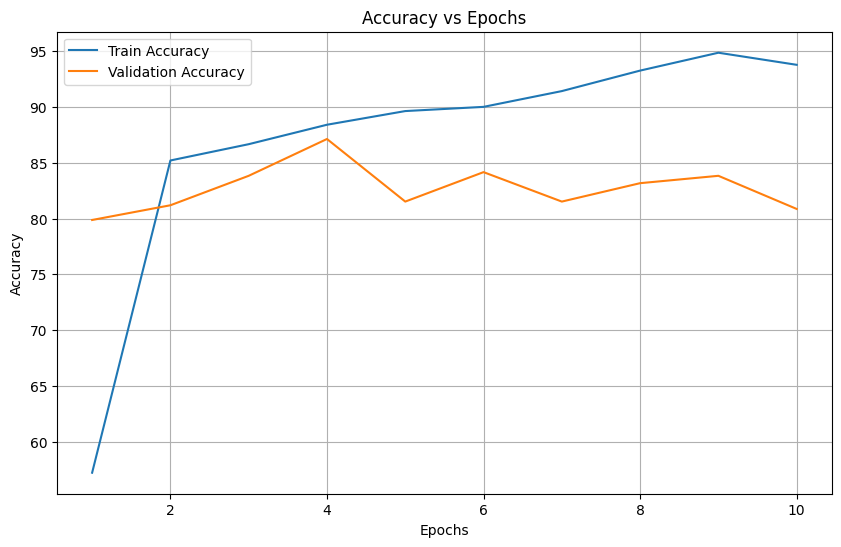

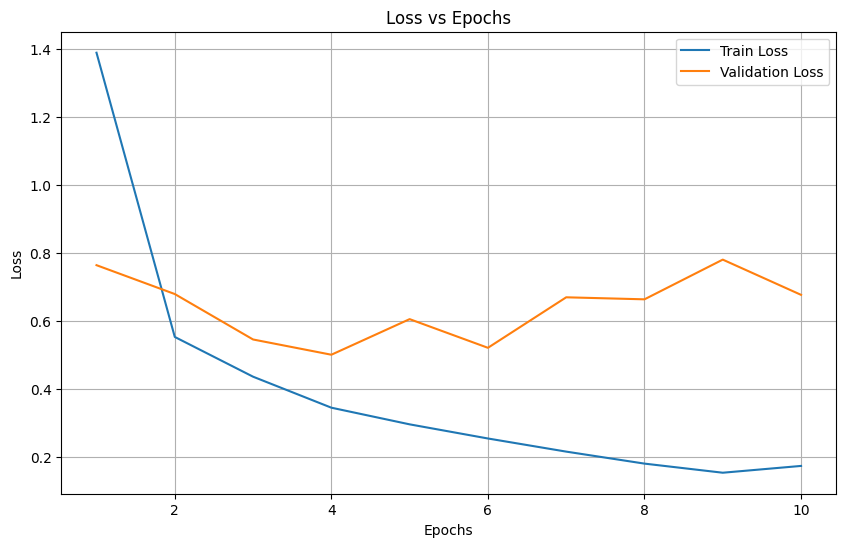

Experimento con: learning rate = 0.0005, batch size = 52, Drop Out = 0.3
Epoch 1/10, Train Loss: 1.3148, Train Accuracy: 60.60%, Validation Loss: 0.6046, Validation Accuracy: 84.82%
Epoch 2/10, Train Loss: 0.5437, Train Accuracy: 84.12%, Validation Loss: 0.5544, Validation Accuracy: 85.15%
Epoch 3/10, Train Loss: 0.4212, Train Accuracy: 86.90%, Validation Loss: 0.4799, Validation Accuracy: 84.16%
Epoch 4/10, Train Loss: 0.3528, Train Accuracy: 87.89%, Validation Loss: 0.5991, Validation Accuracy: 81.85%
Epoch 5/10, Train Loss: 0.2968, Train Accuracy: 89.44%, Validation Loss: 0.5329, Validation Accuracy: 82.84%
Epoch 6/10, Train Loss: 0.2566, Train Accuracy: 90.15%, Validation Loss: 0.5653, Validation Accuracy: 84.16%
Epoch 7/10, Train Loss: 0.2030, Train Accuracy: 92.13%, Validation Loss: 0.6130, Validation Accuracy: 83.17%
Epoch 8/10, Train Loss: 0.1849, Train Accuracy: 92.51%, Validation Loss: 0.6159, Validation Accuracy: 83.17%
Epoch 9/10, Train Loss: 0.1771, Train Accuracy: 93.12%,

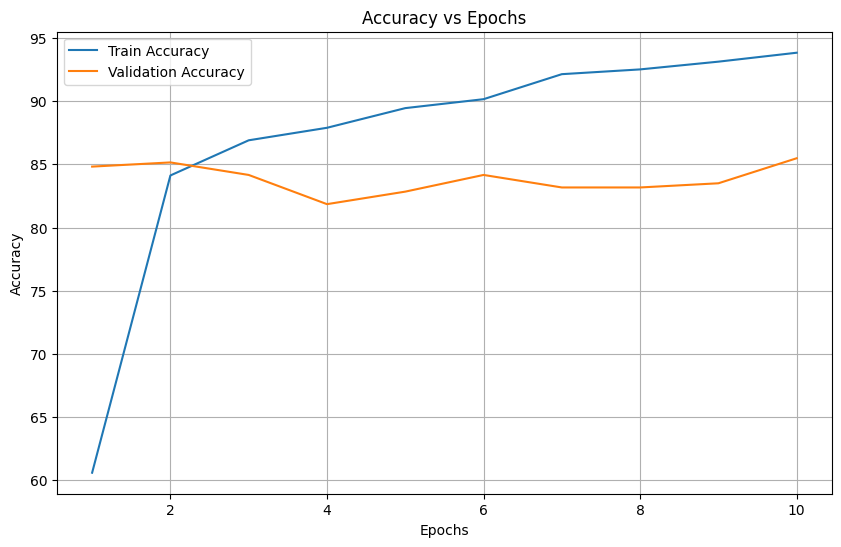

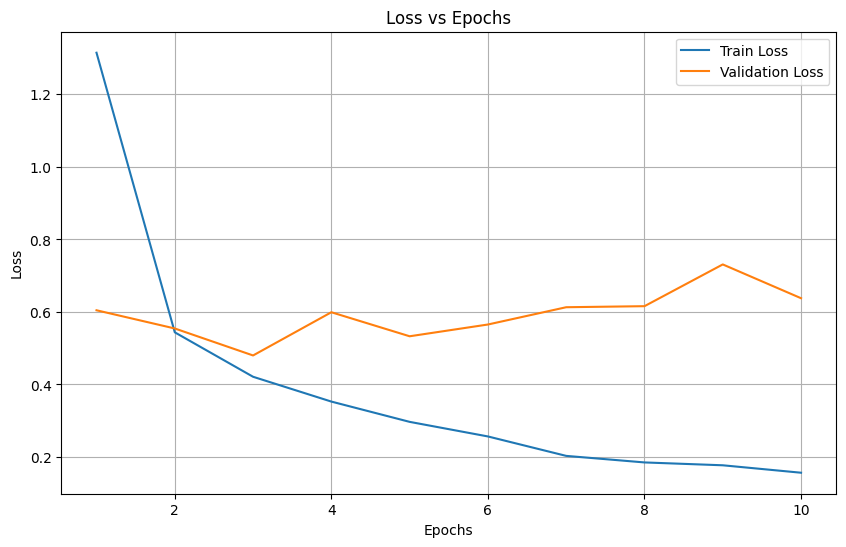

Experimento con: learning rate = 0.0005, batch size = 52, Drop Out = 0.1
Epoch 1/10, Train Loss: 1.1404, Train Accuracy: 67.11%, Validation Loss: 0.6630, Validation Accuracy: 80.86%
Epoch 2/10, Train Loss: 0.5237, Train Accuracy: 85.39%, Validation Loss: 0.5128, Validation Accuracy: 87.13%
Epoch 3/10, Train Loss: 0.4241, Train Accuracy: 86.15%, Validation Loss: 0.5038, Validation Accuracy: 86.47%
Epoch 4/10, Train Loss: 0.3328, Train Accuracy: 88.97%, Validation Loss: 0.5490, Validation Accuracy: 85.48%
Epoch 5/10, Train Loss: 0.3030, Train Accuracy: 89.02%, Validation Loss: 0.5346, Validation Accuracy: 83.50%
Epoch 6/10, Train Loss: 0.2304, Train Accuracy: 91.38%, Validation Loss: 0.5277, Validation Accuracy: 84.49%
Epoch 7/10, Train Loss: 0.2137, Train Accuracy: 92.32%, Validation Loss: 0.6076, Validation Accuracy: 83.50%
Epoch 8/10, Train Loss: 0.1767, Train Accuracy: 93.31%, Validation Loss: 0.7097, Validation Accuracy: 82.18%
Epoch 9/10, Train Loss: 0.1546, Train Accuracy: 94.25%,

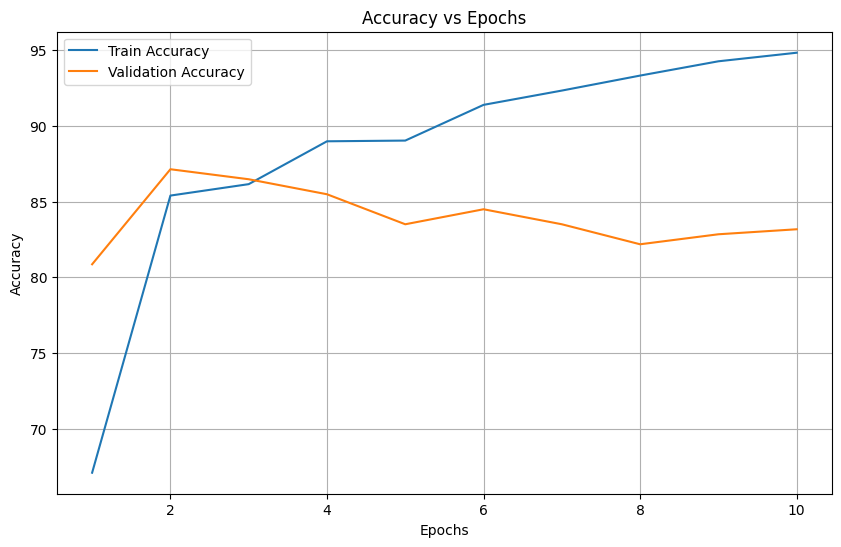

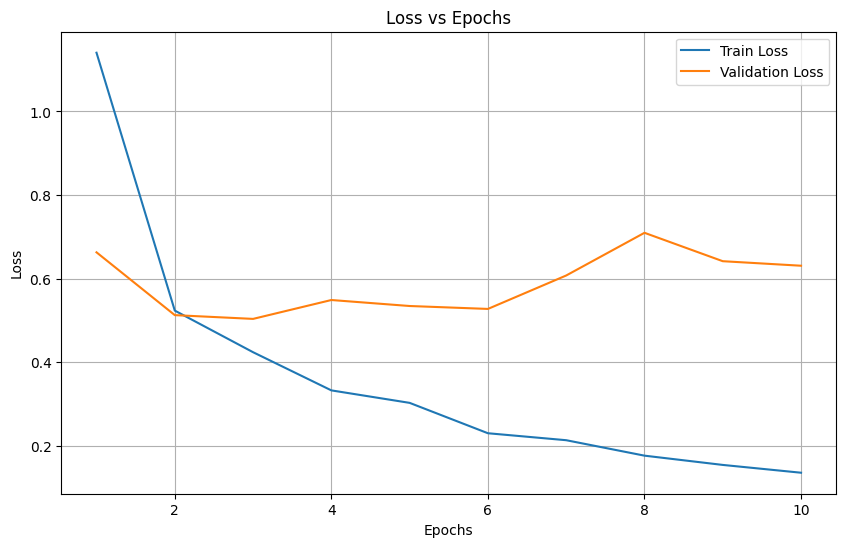

In [ ]:
# ------------------- Definir el Dataset ------------------- #
class UNOCardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))

        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        # Cargar etiqueta
        with open(label_path, 'r') as label_file:
            label = int(label_file.readline().strip())

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------- Definir el modelo CNN ------------------- #
class CNNModel(nn.Module):
    def __init__(self, num_classes=15, drop_out=0.5):
        super(CNNModel, self).__init__()
        # Actualizado kernel_size a 5
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------- Configuración del entrenamiento ------------------- #
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Cargar los datasets
train_dataset = UNOCardDataset('/content/detections/train/', '/content/detections/train/', transform=transform)
val_dataset = UNOCardDataset('/content/detections/val/', '/content/detections/val/', transform=transform)

# Crear subconjuntos balanceados
train_indices, _ = train_test_split(np.arange(len(train_dataset)), test_size=0.9, stratify=[label for _, label in train_dataset], random_state=42)
val_indices, _ = train_test_split(np.arange(len(val_dataset)), test_size=0.9, stratify=[label for _, label in val_dataset], random_state=42)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

# ------------------- Función de entrenamiento ------------------- #
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        metrics['train_loss'].append(running_loss / len(train_loader))
        metrics['train_accuracy'].append(100 * correct / total)
        metrics['train_precision'].append(precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))
        metrics['train_recall'].append(recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds)))

        val_loss, val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {metrics['train_loss'][-1]:.4f}, Train Accuracy: {metrics['train_accuracy'][-1]:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    plot_metrics(metrics)

# ------------------- Función de evaluación ------------------- #
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    val_recall = recall_score(all_labels, all_preds, average='weighted', labels=np.unique(all_preds))
    return val_loss, val_accuracy, val_precision, val_recall

# ------------------- Graficar métricas ------------------- #
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


for learning_rate in learning_rates:
  for batch_size in batch_sizes:
    for drop_out in drop_outs:

      print(f'Experimento con: learning rate = {learning_rate}, batch size = {batch_size}, Drop Out = {drop_out}')

      # Dataloaders con batch_size
      train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

      # ------------------- Ejecutar el modelo ------------------- #
      model = CNNModel(num_classes=15, drop_out=drop_out)
      train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=learning_rate)

### Observaciones:

Una vez finalizada la búsqueda por grilla, se obtuvieron los siguientes resultados:

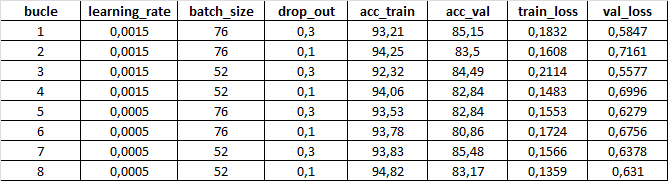

Nuevamente, vale mencionar que las pérdidas y métricas corresponden a la finalización del experimento. Para sacar conclusiones sobre sobreajuste y subajuste se debe analizar las gráficas generadas.

Con lo anterior, se identificó que los mejores resultados se dieron con los siguientes hiperparámetros:

|hiperparámetro|valor   |
|--------------|--------|
|learning rate | 0.0010 |
|batch size    | 64     |
|drop out      | 0.3    |

Estos, junto a num epochs = 10 y kernel size = 5, se utilizan en la notebook: YOLO+RGB+Clasificador